**PART 1: Data Extraction and Feature Extraction with Preprocessing**

In [69]:
'''
1. Pre - Requisite
Install all Library
'''
# 1) Upgrade core tooling inside THIS kernel
%pip install --upgrade pip setuptools wheel --user

# 2) Clean install of audio deps (librosa works with Py3.12 now via numba>=0.61)
%pip install librosa==0.11.0 numba==0.61.2 llvmlite soxr soundfile ffmpeg-python matplotlib tqdm pandas numpy --user

%pip install pandas numpy librosa torchaudio tqdm ffmpeg-python matplotlib soundfile --user
%pip install --upgrade moviepy imageio-ffmpeg torchaudio soundfile numpy tqdm --user

Note: you may need to restart the kernel to use updated packages.


   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----------------------------------- ---- 1.6/1.8 MB 20.8 MB/s eta 0:00:01
   ----------------------------------- ---- 1.6/1.8 MB 20.8 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 3.7 MB/s  0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.2
    Uninstalling pip-25.2:
      Successfully uninstalled pip-25.2
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/665.4 kB ? eta -:--:--
   ------------------------------ -------- 524.3/665.4 kB 16.4 MB/s eta 0:00:01
   ---------------------------------------- 665.4/665.4 kB 8.6 MB/s  0:00:00
   ---------------------------------------- 0.0/109.3 MB ? eta -:--:--
   - -------------------------------------- 2.9/109.3 MB 13.9 MB/s eta 0:00:08
   -- ------------------------------------- 5.8/109.3 MB 14.1 MB/s eta 0:00:08
   --- ------------------------------------ 8.9/109.3 MB 13.8 MB/s eta 0:00:08
   ---- ----------------------------------- 11.5/109.3 MB 13.6 MB/s eta 0:00:08
   ----- ---------------------------------- 14.9/109.3 MB 14.0 MB/s eta 0:00:07
   ------ --------------------------------- 18.6/109.3 MB 14.5 MB/s eta 0:00:07
   -------- ------------------------------- 22.0/109.3 MB 14.8 MB/s eta 0:00:06
   --------- ------------------------------ 25.4/109.3 MB 14.8 MB/s eta 0:00:06
  

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.16.1 requires numpy<2.0.0,>=1.26.0; python_version >= "3.12", but you have numpy 2.3.4 which is incompatible.
torchvision 0.20.1+cu121 requires torch==2.5.1+cu121, but you have torch 2.9.0 which is incompatible.
numba 0.61.2 requires numpy<2.3,>=1.24, but you have numpy 2.3.4 which is incompatible.


In [71]:
import os, sys, json, random, subprocess, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import librosa, librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import Audio, display
from SoccerNet.Downloader import SoccerNetDownloader
import torchaudio

In [ ]:
SN_ROOT = Path(r"C:/Users/CYBORG 15/Documents/GitHub/elec5305-project-520038655/SoccerNet")
SN_ROOT.mkdir(parents=True, exist_ok=True)

SOCCERNET_NDA = ""

# Workspace
WORK_DIR  = Path("./sn_audio_work"); WORK_DIR.mkdir(parents=True, exist_ok=True)
AUDIO_DIR = WORK_DIR / "full_match_audio_wav"; AUDIO_DIR.mkdir(parents=True, exist_ok=True)
CLIPS_DIR = WORK_DIR / "clips";               CLIPS_DIR.mkdir(parents=True, exist_ok=True)
FEAT_DIR  = WORK_DIR / "mel64";               FEAT_DIR.mkdir(parents=True, exist_ok=True)

# Audio + reproducibility
TARGET_SR    = 16000
WINDOWS      = [15, 30]   # 15s/30s event windows
RANDOM_SEED  = 1337
random.seed(RANDOM_SEED)
torchaudio.set_audio_backend("soundfile")  # stable on Windows

print("SN_ROOT:", SN_ROOT)
print("WORK_DIR:", WORK_DIR.resolve())


SN_ROOT: C:\Users\CYBORG 15\Documents\GitHub\elec5305-project-520038655\SoccerNet
WORK_DIR: C:\Users\CYBORG 15\Documents\GitHub\elec5305-project-520038655\sn_audio_work


C:\Users\CYBORG 15\AppData\Local\Temp\ipykernel_29596\959740583.py:17: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")  # stable on Windows


In [73]:
from pathlib import Path
from SoccerNet.Downloader import SoccerNetDownloader
import json

def find_label_files(root: Path):
    files = list(root.rglob("Labels-v2.json"))
    if not files:
        files = list(root.rglob("Labels.json"))
    print(f"Found label files: {len(files)}")
    return files

def _parse_time_mmss(s: str):
    parts = s.split(":")
    try:
        if len(parts)==3:
            hh,mm,ss = parts; return int(hh)*3600 + int(mm)*60 + float(ss)
        if len(parts)==2:
            mm,ss = parts;    return int(mm)*60 + float(ss)
    except Exception:
        return None
    return None

def load_labels_with_half(labels_path: Path):
    """Return list of dicts: {'time_s': float, 'label': str, 'half': 0|1|2}"""
    with open(labels_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    ann = data.get("annotations") or data.get("events") or data.get("labels") or []
    out=[]
    for ev in ann:
        lab  = ev.get("label") or ev.get("event") or ev.get("type")
        if not lab:
            continue
        half = ev.get("half")
        if half not in (1,2):
            gt = ev.get("gameTime")
            if isinstance(gt, str) and " - " in gt:
                try: half = int(gt.split(" - ")[0].strip())
                except: half = None
        pos = ev.get("position")
        t = None
        if isinstance(pos,(int,float)): t = float(pos)
        elif isinstance(pos,str):       t = _parse_time_mmss(pos)
        if t is None:
            gt = ev.get("gameTime")
            if isinstance(gt, str) and " - " in gt:
                t = _parse_time_mmss(gt.split(" - ")[1].strip())
        if t is None:
            continue
        out.append({"time_s": float(t), "label": lab, "half": (half if half in (1,2) else 0)})
    return out

In [74]:
def find_half_videos(match_dir: Path):
    """Return {'1': Path|None, '2': Path|None, 'any': Path|None}"""
    half_map = {1: None, 2: None}
    any_vid = None
    preferred = [
        ("1_720p.mkv", 1), ("2_720p.mkv", 2),
        ("1_224p.mkv", 1), ("2_224p.mkv", 2),
        ("1.mkv", 1),     ("2.mkv", 2),
        ("1.mp4", 1),     ("2.mp4", 2),
    ]
    for name, half in preferred:
        p = match_dir / name
        if p.exists():
            half_map[half] = p
            if any_vid is None: any_vid = p
    if any_vid is None:
        for ext in (".mkv",".mp4",".m4v",".mov"):
            found = list(match_dir.glob(f"*{ext}"))
            if found:
                any_vid = found[0]; break
    return {"1": half_map[1], "2": half_map[2], "any": any_vid}


In [75]:
rows=[]
for lf in tqdm(find_label_files(SN_ROOT), desc="Index labels"):
    mdir  = lf.parent
    split = mdir.parent.name
    evs   = load_labels_with_half(lf)
    if not evs:
        continue
    vids  = find_half_videos(mdir)  # may be all None if videos not yet downloaded
    for e in evs:
        # choose video by half when available, else fallback to any
        video = vids[str(e["half"])] if e["half"] in (1,2) else vids["any"]
        rows.append({
            "split": split,
            "match_dir": str(mdir),
            "labels_json": str(lf),
            "event_time_s": e["time_s"],
            "event_label": e["label"],
            "half": int(e["half"]),
            "video_path": (str(video) if video is not None else None)
        })

df_events = pd.DataFrame(rows).drop_duplicates(
    subset=["match_dir","event_time_s","event_label","half"]
).reset_index(drop=True)

print("Indexed events:", len(df_events))
print("Have video_path for:", df_events["video_path"].notna().sum(), "events")
ALL_LABELS = sorted(df_events["event_label"].unique())
print("Classes:", ALL_LABELS, "| total:", len(ALL_LABELS))


Found label files: 95


Index labels: 100%|██████████| 95/95 [00:00<00:00, 171.01it/s]


Indexed events: 20428
Have video_path for: 9814 events
Classes: ['Ball out of play', 'Clearance', 'Corner', 'Direct free-kick', 'Foul', 'Goal', 'Indirect free-kick', 'Kick-off', 'Offside', 'Penalty', 'Red card', 'Shots off target', 'Shots on target', 'Substitution', 'Throw-in', 'Yellow card', 'Yellow->red card'] | total: 17


In [ ]:
from SoccerNet.Downloader import SoccerNetDownloader
from pathlib import Path

# Create an instance, pointing to your dataset root
mySoccerNetDownloader = SoccerNetDownloader(LocalDirectory=str(SN_ROOT))
mySoccerNetDownloader.password = SOCCERNET_NDA 

print("SoccerNet root:", SN_ROOT)

# ✅ Download labels (small files, safe)
mySoccerNetDownloader.downloadDataTask(task="labels", split=["train","valid","test","challenge"])

# ✅ Download 224p halves, but exclude spain_laliga
splits = ["train","valid","test","challenge"]
for s in splits:
    split_dir = Path(SN_ROOT) / s
    if not split_dir.exists():
        continue
    for comp_dir in split_dir.iterdir():
        if not comp_dir.is_dir():
            continue
        if "spain_laliga" in comp_dir.name:
            print(f"⏭️ Skipping competition: {comp_dir}")
            continue
        print(f"⬇️ Downloading videos for competition: {comp_dir}")
        mySoccerNetDownloader.downloadGames(
            files=["1_224p.mkv", "2_224p.mkv"],
            split=[s]
        )
# Create an instance, pointing to your dataset root
mySoccerNetDownloader = SoccerNetDownloader(LocalDirectory=str(SN_ROOT))
mySoccerNetDownloader.password = SOCCERNET_NDA

print("SoccerNet root:", SN_ROOT)

# ✅ Ensure labels are present (small JSON files, will skip if already exist)
mySoccerNetDownloader.downloadDataTask(task="labels", split=["train","valid","test","challenge"])

# Instead: scan and list what’s already downloaded
video_exts = {".mkv", ".mp4", ".m4v", ".mov"}
downloaded_videos = []
for f in SN_ROOT.rglob("*"):
    if f.suffix in video_exts and f.name.startswith(("1_", "2_")):
        downloaded_videos.append(f)

print(f"[Scan] Total video halves found: {len(downloaded_videos)}")
if downloaded_videos:
    # Show just the first 10 to avoid huge spam
    for v in sorted(downloaded_videos)[:10]:
        print(" -", v.relative_to(SN_ROOT))
    if len(downloaded_videos) > 10:
        print(f"... and {len(downloaded_videos)-10} more")
else:
    print("⚠️ No video halves found. Check your dataset folder.")

SoccerNet root: C:\Users\CYBORG 15\Documents\GitHub\elec5305-project-520038655\SoccerNet
ERROR Unknown task: labels
SoccerNet root: C:\Users\CYBORG 15\Documents\GitHub\elec5305-project-520038655\SoccerNet
ERROR Unknown task: labels
[Scan] Total video halves found: 95
 - england_epl\2014-2015\2015-02-21 - 18-00 Chelsea 1 - 1 Burnley\1_224p.mkv
 - england_epl\2014-2015\2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal\1_224p.mkv
 - england_epl\2014-2015\2015-02-21 - 18-00 Swansea 2 - 1 Manchester United\1_224p.mkv
 - england_epl\2014-2015\2015-02-22 - 19-15 Southampton 0 - 2 Liverpool\1_224p.mkv
 - england_epl\2014-2015\2015-04-11 - 19-30 Burnley 0 - 1 Arsenal\1_224p.mkv
 - england_epl\2014-2015\2015-05-17 - 18-00 Manchester United 1 - 1 Arsenal\1_224p.mkv
 - england_epl\2015-2016\2015-08-08 - 19-30 Chelsea 2 - 2 Swansea\1_224p.mkv
 - england_epl\2015-2016\2015-08-16 - 18-00 Manchester City 3 - 0 Chelsea\1_224p.mkv
 - england_epl\2015-2016\2015-08-23 - 15-30 West Brom 2 - 3 Chelsea\1_224p.

In [77]:
from pathlib import Path
import re, shutil
import pandas as pd
from SoccerNet.Downloader import SoccerNetDownloader

# --- config ---
NEEDED_FILES = ["1_224p.mkv", "2_224p.mkv"]
DROP_COMP     = "spain_laliga"
CANON_COMPS   = [
    "england_epl",
    "europe_uefa-champions-league",
    "france_ligue-1",
    "germany_bundesliga",
    "italy_serie-a",
]

# --- helper: parse competition/season from your on-disk layout ---
SEASON_RE = re.compile(r"^\d{4}-\d{4}$")
def find_label_game_dirs(root: Path):
    return [p.parent for p in root.rglob("Labels*.json")]

def parse_comp_season_from_game_dir(game_dir: Path, root: Path):
    parts = game_dir.relative_to(root).parts
    comp = None; season = None
    for i, p in enumerate(parts):
        if p in (set(CANON_COMPS) | {DROP_COMP}):
            comp = p
            if i+1 < len(parts) and SEASON_RE.match(parts[i+1]):
                season = parts[i+1]
            break
    if comp is None and len(parts) >= 1:
        comp = parts[0]
    if season is None:
        for p in parts:
            if SEASON_RE.match(p): season = p; break
    return comp, season

def list_kept_game_dirs(root: Path, keep_comps: list[str]):
    out = []
    for gd in find_label_game_dirs(root):
        comp, _ = parse_comp_season_from_game_dir(gd, root)
        if comp in keep_comps:
            out.append(gd)
    return out

def check_missing_halves(game_dirs: list[Path], need_files=NEEDED_FILES):
    missing = []
    have = 0
    for g in game_dirs:
        miss = [f for f in need_files if not (g / f).exists()]
        if miss: missing.append((g, miss))
        else:    have += 1
    return have, missing

# --- 0) Make a downloader instance (for labels if ever needed) ---
mySoccerNetDownloader = SoccerNetDownloader(LocalDirectory=str(SN_ROOT))
mySoccerNetDownloader.password = SOCCERNET_NDA

print("SoccerNet root:", SN_ROOT)

# --- 1) Ensure labels exist (fast & small) ---
# Safe to call repeatedly; it skips existing files.
mySoccerNetDownloader.downloadDataTask(task="labels", split=["train","valid","test","challenge"])

# --- 2) Inventory competitions present from labels ---
label_games = find_label_game_dirs(SN_ROOT)
print(f"[Labels] Games with labels found: {len(label_games)}")

inventory = {}
for gd in label_games:
    comp, season = parse_comp_season_from_game_dir(gd, SN_ROOT)
    inventory.setdefault(comp, set())
    if season: inventory[comp].add(season)

# Warn if LaLiga exists; delete or ignore as you wish (here: just ignore printing)
if DROP_COMP in inventory and len(inventory[DROP_COMP]) > 0:
    print(f"⚠️ Found '{DROP_COMP}' labels on disk. They will be excluded from processing.")
else:
    print("✅ 'spain_laliga' not present — nothing to exclude.")

# --- 3) Build kept list (exclude LaLiga; keep canonical comps that exist) ---
KEEP_COMPETITIONS = [c for c in CANON_COMPS if c in inventory]
print("Keeping competitions:", KEEP_COMPETITIONS)

# --- 4) Filter to kept games and check which are complete (both halves) ---
keep_game_dirs = list_kept_game_dirs(SN_ROOT, KEEP_COMPETITIONS)
have_count, missing_list = check_missing_halves(keep_game_dirs, NEEDED_FILES)

print(f"[Scan] Kept games (labels): {len(keep_game_dirs)}")
print(f"[Scan] Complete (both halves present): {have_count}")
print(f"[Scan] Incomplete/missing: {len(missing_list)}")

# --- 5) Use ONLY the complete games; no further downloads requested ---
complete_games = [g for g in keep_game_dirs if all((g/f).exists() for f in NEEDED_FILES)]

# Small assertion/print
if len(complete_games) == 0:
    print("❌ No complete games found. If this is unexpected, double-check paths or consider downloading missing halves.")
else:
    print(f"✅ All data ready: using {len(complete_games)} complete games (excluding '{DROP_COMP}').")

# --- 6) Save list of complete game directories for downstream preprocessing ---
complete_df = pd.DataFrame({"game_dir": [str(g) for g in complete_games]})
COMPLETE_LIST_CSV = (WORK_DIR / "complete_games_224p.csv")
complete_df.to_csv(COMPLETE_LIST_CSV, index=False)
print("Saved list of complete games to:", COMPLETE_LIST_CSV)


SoccerNet root: C:\Users\CYBORG 15\Documents\GitHub\elec5305-project-520038655\SoccerNet
ERROR Unknown task: labels
[Labels] Games with labels found: 190
✅ 'spain_laliga' not present — nothing to exclude.
Keeping competitions: ['england_epl']
[Scan] Kept games (labels): 190
[Scan] Complete (both halves present): 0
[Scan] Incomplete/missing: 190
❌ No complete games found. If this is unexpected, double-check paths or consider downloading missing halves.
Saved list of complete games to: sn_audio_work\complete_games_224p.csv


In [78]:
from pathlib import Path

def find_label_game_dirs(root: Path):
    """Return list of game dirs that contain Labels*.json."""
    games = []
    for p in root.rglob("Labels*.json"):
        # game dir = parent of label file
        games.append(p.parent)
    return games

def list_competitions_from_labels(root: Path):
    """Return sorted list of (split, competition) tuples present on disk."""
    comps = set()
    for game_dir in find_label_game_dirs(root):
        # Expect: root / split / competition / season / game
        parts = game_dir.relative_to(root).parts
        if len(parts) >= 2:
            split, competition = parts[0], parts[1]
            comps.add((split, competition))
    return sorted(comps)

label_games = find_label_game_dirs(SN_ROOT)
print(f"Games with labels found: {len(label_games)}")
detected = list_competitions_from_labels(SN_ROOT)
print("Detected (split, competition) present from labels:")
for s,c in detected[:15]:
    print(" -", s, "|", c)
print("Total competitions detected:", len({c for _,c in detected}))


Games with labels found: 190
Detected (split, competition) present from labels:
 - england_epl | 2014-2015
 - england_epl | 2015-2016
 - england_epl | 2016-2017
Total competitions detected: 3


In [79]:
# === Cell: EPL inventory per HALF — available if (labels exist in that half) AND (WAV exists) ===
from pathlib import Path
import re, json
import pandas as pd

# Assumes SN_ROOT, AUDIO_DIR, TARGET_SR, TARGET_LABELS exist from earlier cells.
# Fallbacks (safe defaults) if you ran this cell standalone:
try:
    SN_ROOT
except NameError:
    SN_ROOT = Path(r"C:/path/to/SoccerNet")  # <- set me if running standalone
try:
    WORK_DIR
except NameError:
    WORK_DIR  = Path("./sn_audio_work")
try:
    AUDIO_DIR
except NameError:
    AUDIO_DIR = WORK_DIR / "full_match_audio_wav"
try:
    TARGET_SR
except NameError:
    TARGET_SR = 16000
try:
    TARGET_LABELS
except NameError:
    TARGET_LABELS = {
        'Yellow->red card','Ball out of play','Foul','Indirect free-kick','Penalty','Shots off target',
        'Offside','Yellow card','Red card','Goal','Direct free-kick','Substitution','Clearance',
        'Kick-off','Corner','Throw-in','Shots on target'
    }

TARGET_COMP = "england_epl"
SEASON_RE = re.compile(r"^\d{4}-\d{4}$")

def parse_comp_season_from_game_dir(game_dir: Path, root: Path):
    parts = game_dir.relative_to(root).parts
    comp = None; season = None
    for i, p in enumerate(parts):
        if p == TARGET_COMP:
            comp = p
            if i+1 < len(parts) and SEASON_RE.match(parts[i+1]):
                season = parts[i+1]
            break
    if comp is None and len(parts) >= 1:
        comp = parts[0]
    if season is None:
        for p in parts:
            if SEASON_RE.match(p):
                season = p; break
    return comp, season

def find_label_game_dirs(root: Path):
    """All game dirs (any comp) that contain Labels*.json."""
    return [p.parent for p in root.rglob("Labels*.json")]

def _parse_time_mmss(s: str):
    parts = s.split(":")
    try:
        if len(parts)==3:
            hh,mm,ss = parts; return int(hh)*3600 + int(mm)*60 + float(ss)
        if len(parts)==2:
            mm,ss = parts;    return int(mm)*60 + float(ss)
    except Exception:
        return None
    return None

def load_labels_with_half(labels_path: Path):
    """Return list of dicts: {'time_s': float, 'label': str, 'half': int in {1,2}}."""
    with open(labels_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    ann = data.get("annotations") or data.get("events") or data.get("labels") or []
    out=[]
    for ev in ann:
        lab  = ev.get("label") or ev.get("event") or ev.get("type")
        if not lab:
            continue
        half = ev.get("half")
        if half not in (1,2):
            gt = ev.get("gameTime")
            if isinstance(gt, str) and " - " in gt:
                try: half = int(gt.split(" - ")[0].strip())
                except: half = 1
        pos = ev.get("position")
        t = None
        if isinstance(pos,(int,float)): t = float(pos)
        elif isinstance(pos,str):       t = _parse_time_mmss(pos)
        if t is None:
            gt = ev.get("gameTime")
            if isinstance(gt, str) and " - " in gt:
                t = _parse_time_mmss(gt.split(" - ")[1].strip())
        if t is None: 
            continue
        out.append({"time_s": float(t), "label": lab, "half": int(half)})
    return out

def expected_half_wav_path(comp: str, season: str, game: str, half: int, sr: int = TARGET_SR) -> Path:
    # Must match your ensure_half_wav() naming
    return AUDIO_DIR / f"{comp}__{season}__{game}__H{half}_{sr}Hz.wav"

# ---- Build per-half availability ----
label_games = [gd for gd in find_label_game_dirs(SN_ROOT) if parse_comp_season_from_game_dir(gd, SN_ROOT)[0] == TARGET_COMP]
print(f"[Scan] Games with label JSONs under {TARGET_COMP}: {len(label_games)}")

rows = []
missing = []  # halves that have labels but WAV missing

for gd in label_games:
    comp, season = parse_comp_season_from_game_dir(gd, SN_ROOT)
    game = gd.name
    labels_json = (gd / "Labels-v2.json") if (gd / "Labels-v2.json").exists() else (gd / "Labels.json")

    # Which halves have at least one TARGET_LABEL event?
    try:
        evs = load_labels_with_half(labels_json)
    except Exception as e:
        # if label file unparsable, skip this game
        continue
    halves_with_labels = sorted({e["half"] for e in evs if e["label"] in TARGET_LABELS})

    for h in halves_with_labels:
        wav_p = expected_half_wav_path(comp, season, game, h, TARGET_SR)
        if wav_p.exists():
            rows.append({
                "competition": comp,
                "season": season,
                "game": game,
                "game_dir": str(gd),
                "half": h,
                "wav_path": str(wav_p),
                "has_wav": True
            })
        else:
            missing.append((gd, h, wav_p))
            rows.append({
                "competition": comp,
                "season": season,
                "game": game,
                "game_dir": str(gd),
                "half": h,
                "wav_path": str(wav_p),
                "has_wav": False
            })

df_halves = pd.DataFrame(rows).sort_values(["season","game","half"]).reset_index(drop=True)

n_halves_with_labels = len(df_halves)
n_available = int(df_halves["has_wav"].sum())
print(f"[Result] EPL halves with labels: {n_halves_with_labels}")
print(f"[Result] EPL halves READY (labels + WAV present): {n_available}")
print(f"[Result] Missing WAV for {n_halves_with_labels - n_available} halves (show up to 5):")
for gd, h, wp in missing[:5]:
    print(f" - {gd}  H{h}  expected: {wp.name}")

# Optional: keep only the ready halves for downstream use
df_halves_ready = df_halves[df_halves["has_wav"]].reset_index(drop=True)
print(f"\nReady halves DataFrame shape: {df_halves_ready.shape}")
df_halves_ready.head(3)


[Scan] Games with label JSONs under england_epl: 190
[Result] EPL halves with labels: 380
[Result] EPL halves READY (labels + WAV present): 78
[Result] Missing WAV for 302 halves (show up to 5):
 - C:\Users\CYBORG 15\Documents\GitHub\elec5305-project-520038655\SoccerNet\england_epl\2014-2015\2015-02-21 - 18-00 Chelsea 1 - 1 Burnley  H2  expected: england_epl__2014-2015__2015-02-21 - 18-00 Chelsea 1 - 1 Burnley__H2_16000Hz.wav
 - C:\Users\CYBORG 15\Documents\GitHub\elec5305-project-520038655\SoccerNet\england_epl\2014-2015\2015-02-21 - 18-00 Chelsea 1 - 1 Burnley  H2  expected: england_epl__2014-2015__2015-02-21 - 18-00 Chelsea 1 - 1 Burnley__H2_16000Hz.wav
 - C:\Users\CYBORG 15\Documents\GitHub\elec5305-project-520038655\SoccerNet\england_epl\2014-2015\2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal  H2  expected: england_epl__2014-2015__2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal__H2_16000Hz.wav
 - C:\Users\CYBORG 15\Documents\GitHub\elec5305-project-520038655\SoccerNet\england_ep

competition     season                                             game  \
0  england_epl  2014-2015         2015-02-21 - 18-00 Chelsea 1 - 1 Burnley   
1  england_epl  2014-2015         2015-02-21 - 18-00 Chelsea 1 - 1 Burnley   
2  england_epl  2014-2015  2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal   

                                            game_dir  half  \
0  C:\Users\CYBORG 15\Documents\GitHub\elec5305-p...     1   
1  C:\Users\CYBORG 15\Documents\GitHub\elec5305-p...     1   
2  C:\Users\CYBORG 15\Documents\GitHub\elec5305-p...     1   

                                            wav_path  has_wav  
0  sn_audio_work\full_match_audio_wav\england_epl...     True  
1  sn_audio_work\full_match_audio_wav\england_epl...     True  
2  sn_audio_work\full_match_audio_wav\england_epl...     True

In [80]:
# === Build clips + mel features + dataset_index.csv (idempotent + atomic saves + corruption repair) ===
import os, re, json, math, numpy as np, pandas as pd, torch, torchaudio, tempfile
from pathlib import Path
from tqdm import tqdm

# ---- Config (reuse if already defined) ----
SN_ROOT   = Path(globals().get("SN_ROOT", r"C:/Users/YourUser/SoccerNet"))      # << set if needed
WORK_DIR  = Path(globals().get("WORK_DIR", "./sn_audio_work"))
AUDIO_DIR = Path(globals().get("AUDIO_DIR", WORK_DIR / "full_match_audio_wav"))
CLIPS_DIR = Path(globals().get("CLIPS_DIR", WORK_DIR / "clips")); CLIPS_DIR.mkdir(parents=True, exist_ok=True)
FEAT_DIR  = Path(globals().get("FEAT_DIR",  WORK_DIR / "mel64"));  FEAT_DIR.mkdir(parents=True, exist_ok=True)
INDEX_CSV = Path(globals().get("INDEX_CSV", WORK_DIR / "dataset_index.csv"))

TARGET_COMP = "england_epl"
TARGET_SR   = int(globals().get("TARGET_SR", 16000))
N_MELS      = int(globals().get("N_MELS", 64))
N_FFT       = int(globals().get("N_FFT", 1024))
HOP         = int(globals().get("HOP", 320))
WINDOWS     = list(globals().get("WINDOWS", [15, 30]))

# Idempotency & repair controls
OVERWRITE_MELS    = False     # force recompute even if present
OVERWRITE_WAVS    = False     # force rewrite clip wavs
REPAIR_CORRUPT    = True      # recompute invalid/partial npy files
VALIDATE_NPY_SHAPE = (N_MELS, None)  # expected (n_mels, T). None = any T

TARGET_LABELS = set(globals().get("TARGET_LABELS", {
    'Yellow->red card','Ball out of play','Foul','Indirect free-kick','Penalty','Shots off target',
    'Offside','Yellow card','Red card','Goal','Direct free-kick','Substitution','Clearance',
    'Kick-off','Corner','Throw-in','Shots on target'
}))

SEASON_RE = re.compile(r"^\d{4}-\d{4}$")

def _parse_time_mmss(s: str):
    parts = s.split(":")
    try:
        if len(parts)==3: hh,mm,ss = parts; return int(hh)*3600 + int(mm)*60 + float(ss)
        if len(parts)==2: mm,ss = parts; return int(mm)*60 + float(ss)
    except Exception: return None
    return None

def parse_comp_season_from_game_dir(game_dir: Path, root: Path):
    parts = game_dir.relative_to(root).parts
    comp = None; season = None
    for i, p in enumerate(parts):
        if p == TARGET_COMP:
            comp = p
            if i+1 < len(parts) and SEASON_RE.match(parts[i+1]): season = parts[i+1]
            break
    if comp is None and len(parts) >= 1: comp = parts[0]
    if season is None:
        for p in parts:
            if SEASON_RE.match(p): season = p; break
    return comp, season

def find_label_game_dirs(root: Path):
    return [p.parent for p in root.rglob("Labels*.json")]

def load_labels_with_half(labels_path: Path):
    with open(labels_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    ann = data.get("annotations") or data.get("events") or data.get("labels") or []
    out=[]
    for ev in ann:
        lab  = ev.get("label") or ev.get("event") or ev.get("type")
        if not lab: continue
        half = ev.get("half")
        if half not in (1,2):
            gt = ev.get("gameTime")
            if isinstance(gt, str) and " - " in gt:
                try: half = int(gt.split(" - ")[0].strip())
                except: half = 1
        pos = ev.get("position")
        t = float(pos) if isinstance(pos,(int,float)) else (_parse_time_mmss(pos) if isinstance(pos,str) else None)
        if t is None:
            gt = ev.get("gameTime")
            if isinstance(gt, str) and " - " in gt:
                t = _parse_time_mmss(gt.split(" - ")[1].strip())
        if t is None: continue
        out.append({"time_s": float(t), "label": lab, "half": int(half)})
    return out

def expected_half_wav_path(comp: str, season: str, game: str, half: int, sr: int = TARGET_SR) -> Path:
    return AUDIO_DIR / f"{comp}__{season}__{game}__H{half}_{sr}Hz.wav"

def slugify(s: str) -> str:
    return re.sub(r"[^a-z0-9]+","-", s.strip().lower()).strip("-")

# ---- Atomic save helpers ----
def atomic_save_npy(path: Path, arr: np.ndarray):
    path.parent.mkdir(parents=True, exist_ok=True)
    with tempfile.NamedTemporaryFile(delete=False, dir=str(path.parent), suffix=".tmp") as tf:
        tmp = Path(tf.name)
    try:
        np.save(tmp, arr, allow_pickle=False)
        os.replace(tmp, path)  # atomic on Windows/Unix
    finally:
        if tmp.exists():
            try: tmp.unlink()
            except: pass

def atomic_save_wav(path: Path, tensor: torch.Tensor, sr: int):
    path.parent.mkdir(parents=True, exist_ok=True)
    with tempfile.NamedTemporaryFile(delete=False, dir=str(path.parent), suffix=".tmp.wav") as tf:
        tmp = Path(tf.name)
    try:
        torchaudio.save(str(tmp), tensor, sr)
        os.replace(tmp, path)
    finally:
        if tmp.exists():
            try: tmp.unlink()
            except: pass

def is_valid_npy(path: Path, expected_first_dim: int | None = None) -> bool:
    try:
        if not path.exists() or path.stat().st_size == 0:
            return False
        arr = np.load(path, mmap_mode="r")
        if arr.ndim != 2:
            return False
        if expected_first_dim is not None and arr.shape[0] != expected_first_dim:
            return False
        return True
    except Exception:
        return False

# ---------- 1) Collect EPL events with existing half WAV ----------
label_games = [gd for gd in find_label_game_dirs(SN_ROOT) if parse_comp_season_from_game_dir(gd, SN_ROOT)[0] == TARGET_COMP]
rows=[]
for gd in tqdm(label_games, desc="Index labels"):
    comp, season = parse_comp_season_from_game_dir(gd, SN_ROOT)
    game = gd.name
    labels_json = (gd / "Labels-v2.json") if (gd / "Labels-v2.json").exists() else (gd / "Labels.json")
    evs = load_labels_with_half(labels_json)
    for e in evs:
        if e["label"] not in TARGET_LABELS: continue
        wav_p = expected_half_wav_path(comp, season, game, e["half"], TARGET_SR)
        if wav_p.exists():
            rows.append({
                "competition": comp, "season": season, "game": game, "game_dir": str(gd),
                "event_time_s": e["time_s"], "event_label": e["label"], "half": e["half"],
                "audio_wav": str(wav_p)
            })
df_events = pd.DataFrame(rows).drop_duplicates(subset=["game_dir","event_time_s","event_label","half"]).reset_index(drop=True)
print(f"[Events] Kept (labels + half WAV exists): {len(df_events)}")
if df_events.empty:
    raise SystemExit("No events with matching half WAVs found. Put some WAVs in full_match_audio_wav/.")

# ---------- 2) Mel frontend ----------
mel_tf = torchaudio.transforms.MelSpectrogram(
    sample_rate=TARGET_SR, n_fft=N_FFT, hop_length=HOP, win_length=N_FFT,
    n_mels=N_MELS, f_min=0.0, f_max=TARGET_SR/2.0, center=True, pad_mode="reflect", power=2.0
)
amp2db = torchaudio.transforms.AmplitudeToDB(stype="power")

def load_half_wav_cached(wav_path: str, cache: dict) -> torch.Tensor:
    if wav_path in cache: return cache[wav_path]
    wav, sr = torchaudio.load(wav_path)
    if wav.shape[0] > 1: wav = wav.mean(dim=0, keepdim=True)
    if sr != TARGET_SR:  wav = torchaudio.functional.resample(wav, sr, TARGET_SR)
    cache[wav_path] = wav.squeeze(0).contiguous()
    return cache[wav_path]

def cut_centered(signal_1d: torch.Tensor, sr: int, center_s: float, win_s: float) -> torch.Tensor:
    total = signal_1d.numel()
    n_win = int(round(win_s * sr))
    half = n_win // 2
    center = int(round(center_s * sr))
    start = center - half
    end   = start + n_win
    pad_left = max(0, -start)
    pad_right = max(0, end - total)
    if pad_left or pad_right:
        sig = torch.nn.functional.pad(signal_1d, (pad_left, pad_right))
        start = start + pad_left
        end   = start + n_win
        clip = sig[start:end]
    else:
        start = max(0, start); end = min(total, end)
        clip = signal_1d[start:end]
    if clip.numel() != n_win:
        clip = torch.nn.functional.pad(clip, (0, n_win - clip.numel()))
    return clip

# Ensure folders exist
for w in WINDOWS:
    (CLIPS_DIR / f"win{w}s").mkdir(parents=True, exist_ok=True)
    (FEAT_DIR  / f"win{w}s").mkdir(parents=True, exist_ok=True)

# ---------- 3) Generate clips + mels + CSV (skip existing + repair corrupt) ----------
rows_out = []
wav_cache = {}
labels_sorted = sorted(df_events["event_label"].unique())
label_to_id = {lab:i for i,lab in enumerate(labels_sorted)}

pbar = tqdm(df_events.itertuples(index=False), total=len(df_events), desc="Make/collect clips + mels")
for r in pbar:
    comp, season, game = r.competition, r.season, r.game
    half, t_s = int(r.half), float(r.event_time_s)
    label     = r.event_label
    label_id  = label_to_id[label]
    half_wav  = r.audio_wav

    # Decide which windows actually need recompute (missing or corrupt or overwrite)
    plan_windows = []
    for win_s in WINDOWS:
        stem = f"{comp}__{season}__{game}__H{half}__{slugify(label)}__t{int(round(t_s*1000))}ms__w{win_s}s"
        wav_out  = CLIPS_DIR / f"win{win_s}s" / f"{stem}.wav"
        mel_out  = FEAT_DIR  / f"win{win_s}s" / f"{stem}.npy"

        mel_exists = mel_out.exists()
        mel_valid  = is_valid_npy(mel_out, expected_first_dim=VALIDATE_NPY_SHAPE[0]) if mel_exists else False
        need_mel   = OVERWRITE_MELS or (not mel_exists) or (REPAIR_CORRUPT and not mel_valid)

        if need_mel:
            plan_windows.append((win_s, stem, wav_out, mel_out))

    # If nothing to do, just consume existing valid mels
    if not plan_windows:
        for win_s in WINDOWS:
            stem = f"{comp}__{season}__{game}__H{half}__{slugify(label)}__t{int(round(t_s*1000))}ms__w{win_s}s"
            wav_out  = CLIPS_DIR / f"win{win_s}s" / f"{stem}.wav"
            mel_out  = FEAT_DIR  / f"win{win_s}s" / f"{stem}.npy"
            if is_valid_npy(mel_out, expected_first_dim=N_MELS):
                mel = np.load(mel_out, mmap_mode="r")
                rows_out.append({
                    "competition": comp, "season": season, "game": game, "half": half,
                    "t_center_s": t_s, "win_s": win_s, "event_label": label, "label_id": label_id,
                    "audio_wav": str(wav_out), "mel_npy": str(mel_out),
                    "frames": int(mel.shape[1]), "n_mels": int(mel.shape[0]),
                })
        continue

    # Work needed → load half once
    full = load_half_wav_cached(half_wav, wav_cache)

    # Compute/rewrite for the windows that need it
    for (win_s, stem, wav_out, mel_out) in plan_windows:
        clip = cut_centered(full, TARGET_SR, t_s, win_s)

        if OVERWRITE_WAVS or (not wav_out.exists()):
            atomic_save_wav(wav_out, clip.unsqueeze(0), TARGET_SR)

        with torch.no_grad():
            mel = mel_tf(clip.unsqueeze(0))
            mel_db = amp2db(mel).squeeze(0).cpu().numpy()
            mu, sd = mel_db.mean(), mel_db.std() + 1e-8
            mel_db = (mel_db - mu) / sd

        atomic_save_npy(mel_out, mel_db)

    # Append rows for all windows (now guaranteed valid)
    for win_s in WINDOWS:
        stem = f"{comp}__{season}__{game}__H{half}__{slugify(label)}__t{int(round(t_s*1000))}ms__w{win_s}s"
        wav_out  = CLIPS_DIR / f"win{win_s}s" / f"{stem}.wav"
        mel_out  = FEAT_DIR  / f"win{win_s}s" / f"{stem}.npy"
        if is_valid_npy(mel_out, expected_first_dim=N_MELS):
            mel = np.load(mel_out, mmap_mode="r")
            rows_out.append({
                "competition": comp, "season": season, "game": game, "half": half,
                "t_center_s": t_s, "win_s": win_s, "event_label": label, "label_id": label_id,
                "audio_wav": str(wav_out), "mel_npy": str(mel_out),
                "frames": int(mel.shape[1]), "n_mels": int(mel.shape[0]),
            })

# ---------- 4) Merge/build index ----------
new_index = pd.DataFrame(rows_out).sort_values(
    ["season","game","half","t_center_s","win_s"]
).reset_index(drop=True)

if INDEX_CSV.exists():
    old_index = pd.read_csv(INDEX_CSV)
    combo = pd.concat([old_index, new_index], ignore_index=True)
    combo.drop_duplicates(subset=["mel_npy"], inplace=True)
    combo.sort_values(["season","game","half","t_center_s","win_s"], inplace=True)
    combo.reset_index(drop=True, inplace=True)
    combo.to_csv(INDEX_CSV, index=False)
    print(f"[Done] Updated index → {INDEX_CSV} (old {len(old_index)} + new {len(new_index)} → unique {len(combo)})")
    display(combo.head(5))
else:
    new_index.to_csv(INDEX_CSV, index=False)
    print(f"[Done] Wrote {len(new_index)} rows → {INDEX_CSV}")
    display(new_index.head(5))

Index labels: 100%|██████████| 190/190 [00:02<00:00, 93.87it/s] 


[Events] Kept (labels + half WAV exists): 3969


Make/collect clips + mels: 100%|██████████| 3969/3969 [00:50<00:00, 78.46it/s] 


[Done] Updated index → sn_audio_work\dataset_index.csv (old 7938 + new 7937 → unique 7938)


competition     season                                      game  half  \
0  england_epl  2014-2015  2015-02-21 - 18-00 Chelsea 1 - 1 Burnley     1   
1  england_epl  2014-2015  2015-02-21 - 18-00 Chelsea 1 - 1 Burnley     1   
2  england_epl  2014-2015  2015-02-21 - 18-00 Chelsea 1 - 1 Burnley     1   
3  england_epl  2014-2015  2015-02-21 - 18-00 Chelsea 1 - 1 Burnley     1   
4  england_epl  2014-2015  2015-02-21 - 18-00 Chelsea 1 - 1 Burnley     1   

   t_center_s  win_s       event_label  label_id  \
0         0.0     15          Kick-off         7   
1         0.0     30          Kick-off         7   
2       133.0     15  Ball out of play         0   
3       133.0     30  Ball out of play         0   
4       149.0     15          Throw-in        14   

                                           audio_wav  \
0  sn_audio_work\clips\win15s\england_epl__2014-2...   
1  sn_audio_work\clips\win30s\england_epl__2014-2...   
2  sn_audio_work\clips\win15s\england_epl__2014-2...   
3  sn_audio_work\clips\win30s\england_epl__2014-2...   
4  sn_audio_work\clips\win15s\england_epl__2014-2...   

                                             mel_npy  frames  n_mels  
0  sn_audio_work\mel64\win15s\england_epl__2014-2...     751      64  
1  sn_audio_work\mel64\win30s\england_epl__2014-2...    1501      64  
2  sn_audio_work\mel64\win15s\england_epl__2014-2...     751      64  
3  sn_audio_work\mel64\win30s\england_epl__2014-2...    1501      64  
4  sn_audio_work\mel64\win15s\england_epl__2014-2...     751      64

**Part 2: Data Exploration**

Inspecting: england_epl__2014-2015__2015-02-21 - 18-00 Chelsea 1 - 1 Burnley__H1__ball-out-of-play__t1008000ms__w15s.wav
Duration: 15.00s @ 16000 Hz


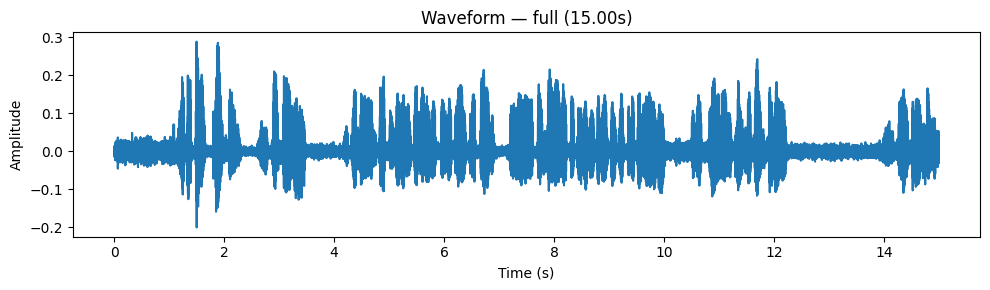

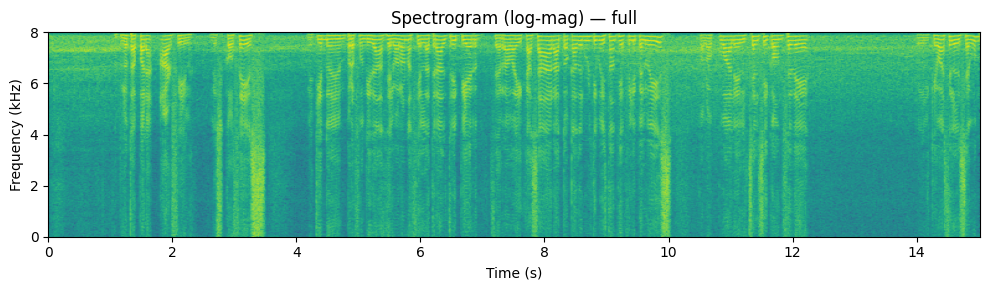

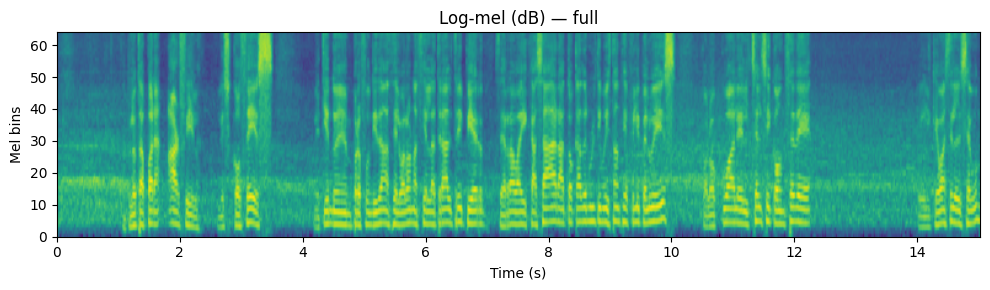


Reference time (center): 7.50s

— Window 15s around 7.50s —


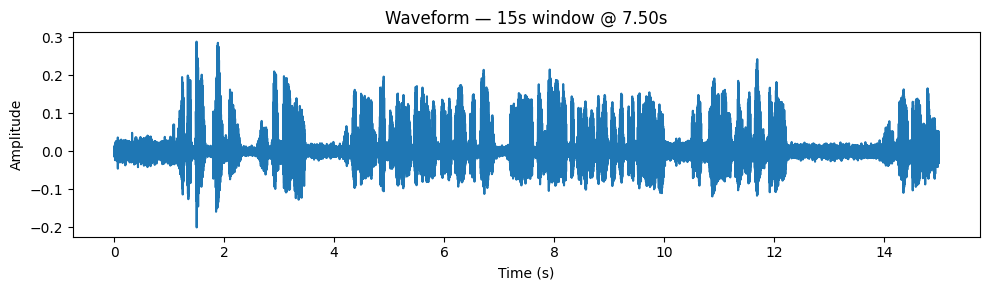

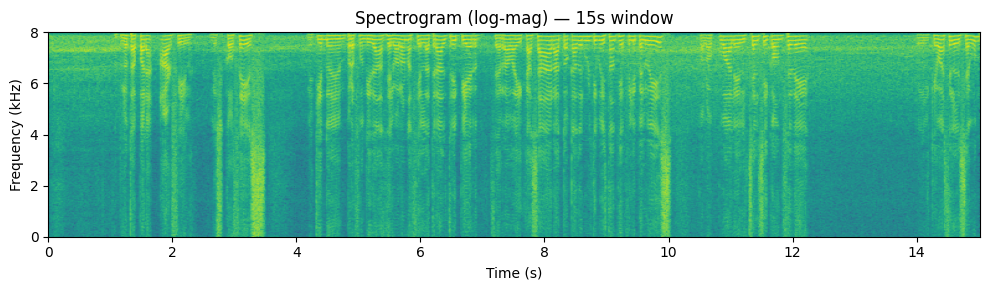

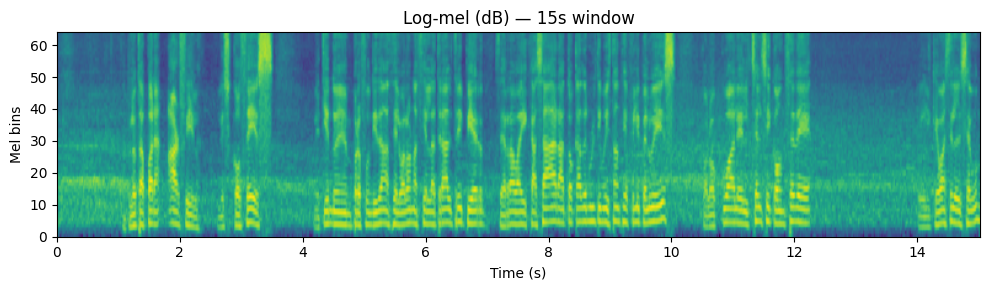


— Window 30s around 7.50s —


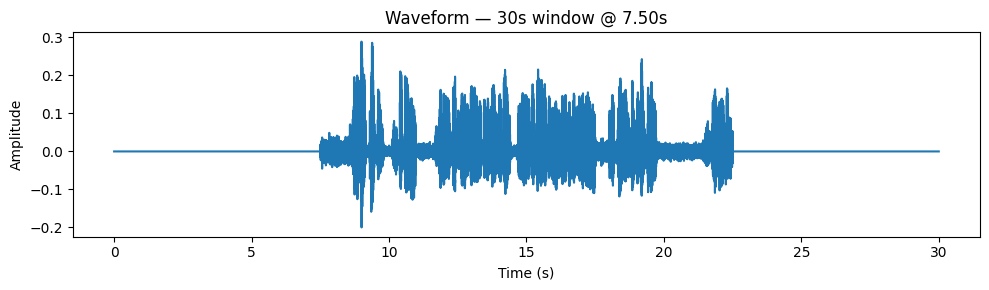

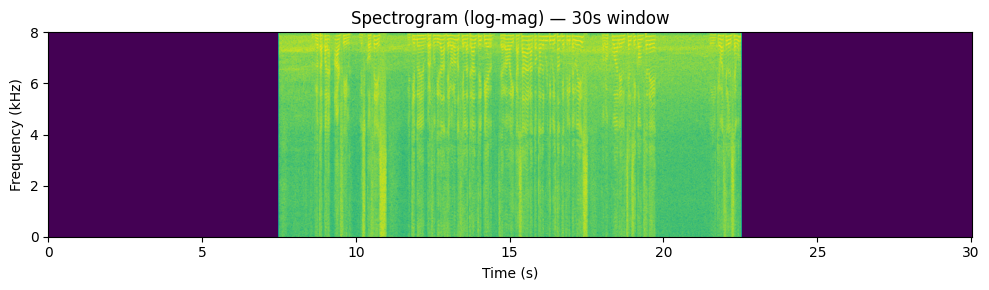

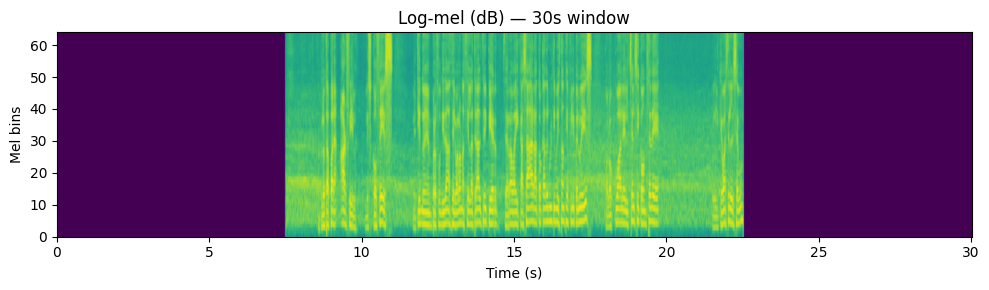


Saved PNGs to: sn_audio_work\quick_viz


In [81]:
# === Audio Explorer: waveform + STFT + log-mel for full & windows ===
from pathlib import Path
import re, math
import numpy as np
import torch, torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# ---------------- Config ----------------
WORK_DIR  = Path(globals().get("WORK_DIR", "./sn_audio_work"))
AUDIO_DIR = Path(globals().get("AUDIO_DIR", WORK_DIR / "full_match_audio_wav"))
CLIPS_DIR = Path(globals().get("CLIPS_DIR", WORK_DIR / "clips"))
VIZ_DIR   = WORK_DIR / "quick_viz"; VIZ_DIR.mkdir(parents=True, exist_ok=True)

# DSP (reuse globals if set)
TARGET_SR = int(globals().get("TARGET_SR", 16000))
N_FFT     = int(globals().get("N_FFT", 1024))
HOP       = int(globals().get("HOP", 320))
N_MELS    = int(globals().get("N_MELS", 64))

# Selection
WINDOWS_S  = [15, 30]      # compare these windows (seconds)
KEYWORD    = None          # e.g., "goal", or part of a filename; None = no filter
MANUAL_WAV = None          # e.g., Path("sn_audio_work/clips/win30s/england_epl__...wav"); None=auto pick

# Optional: choose a reference time (seconds) in the audio to center windows around.
# - For event-centered clips, leave None to use the middle of the file.
# - For half-match WAVs, set a time, e.g., REF_T = 1234.5
REF_T = None

# ---------------- Helpers ----------------
def pick_wav():
    cand = []
    # Prefer event clips (smaller), then full halves
    cand += sorted(CLIPS_DIR.rglob("*.wav"))
    cand += sorted(AUDIO_DIR.rglob("*.wav"))
    if KEYWORD:
        cand = [p for p in cand if KEYWORD.lower() in p.name.lower()]
    return cand[0] if cand else None

def load_mono(path: Path, target_sr: int):
    x, sr = torchaudio.load(str(path))
    if x.shape[0] > 1:
        x = x.mean(dim=0, keepdim=True)
    if sr != target_sr:
        x = torchaudio.functional.resample(x, sr, target_sr)
        sr = target_sr
    return x.squeeze(0).contiguous(), sr  # [T], sr

def center_slice(x: torch.Tensor, sr: int, center_t: float, win_s: float):
    total = x.numel()
    n = int(round(win_s * sr))
    c = int(round(center_t * sr))
    s = c - n//2
    e = s + n
    pad_left = max(0, -s)
    pad_right = max(0, e - total)
    if pad_left or pad_right:
        xpad = torch.nn.functional.pad(x, (pad_left, pad_right))
        s = s + pad_left; e = s + n
        return xpad[s:e]
    s = max(0, s); e = min(total, e)
    out = x[s:e]
    if out.numel() != n:
        out = torch.nn.functional.pad(out, (0, n - out.numel()))
    return out

def stft_db(x: torch.Tensor, n_fft: int, hop: int):
    win = torch.hann_window(n_fft)
    X = torch.stft(x, n_fft=n_fft, hop_length=hop, window=win, return_complex=True, center=True)
    S = X.abs().clamp_min(1e-10)
    return 20.0 * torch.log10(S)

def mel_db(x: torch.Tensor, sr: int, n_fft: int, hop: int, n_mels: int):
    mel = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr, n_fft=n_fft, hop_length=hop, win_length=n_fft,
        n_mels=n_mels, f_min=0.0, f_max=sr/2, power=2.0, center=True, pad_mode="reflect"
    )(x.unsqueeze(0)).squeeze(0)
    db = torchaudio.transforms.AmplitudeToDB(stype="power")(mel)
    return db

def plot_wave(x, sr, title, save=None):
    t = torch.arange(x.numel())/sr
    plt.figure(figsize=(10,3))
    plt.plot(t.numpy(), x.cpu().numpy())
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude"); plt.title(title)
    plt.tight_layout()
    if save: plt.savefig(save, dpi=150)
    plt.show()

def plot_stft(S_db, sr, hop, title, save=None):
    # S_db: [freq_bins, T]; freq axis (Hz), time axis (s)
    plt.figure(figsize=(10,3))
    extent = [0, S_db.shape[1]*hop/sr, 0, sr/2/1000.0]  # time sec, freq kHz
    plt.imshow(S_db.flip(0).cpu().numpy(), aspect='auto', extent=extent, origin='lower')
    plt.xlabel("Time (s)"); plt.ylabel("Frequency (kHz)"); plt.title(title)
    plt.tight_layout()
    if save: plt.savefig(save, dpi=150)
    plt.show()

def plot_mel(M_db, sr, hop, title, save=None):
    plt.figure(figsize=(10,3))
    extent = [0, M_db.shape[1]*hop/sr, 0, M_db.shape[0]]
    plt.imshow(M_db.cpu().numpy(), aspect='auto', extent=extent, origin='lower')
    plt.xlabel("Time (s)"); plt.ylabel("Mel bins"); plt.title(title)
    plt.tight_layout()
    if save: plt.savefig(save, dpi=150)
    plt.show()

# ---------------- Run ----------------
wav_path = MANUAL_WAV if MANUAL_WAV else pick_wav()
if wav_path is None:
    raise SystemExit("No WAV found in clips/ or full_match_audio_wav/. Fill those first.")

x, sr = load_mono(wav_path, TARGET_SR)
dur = x.numel()/sr
print(f"Inspecting: {wav_path.name}\nDuration: {dur:.2f}s @ {sr} Hz")

# Full clip preview (limit playback to 20s for convenience)
display(Audio(x[:min(x.numel(), 20*sr)].cpu().numpy(), rate=sr))

# Full clip plots
plot_wave(x, sr, f"Waveform — full ({dur:.2f}s)", save=VIZ_DIR/(wav_path.stem+"_full_wave.png"))
S_db_full = stft_db(x, N_FFT, HOP)
plot_stft(S_db_full, sr, HOP, "Spectrogram (log-mag) — full", save=VIZ_DIR/(wav_path.stem+"_full_spec.png"))
M_db_full = mel_db(x, sr, N_FFT, HOP, N_MELS)
plot_mel(M_db_full, sr, HOP, "Log-mel (dB) — full", save=VIZ_DIR/(wav_path.stem+"_full_mel.png"))

# Choose a reference time for windowed views
if REF_T is None:
    REF_T = dur/2.0  # middle of file is a good default for event-centered clips

print(f"\nReference time (center): {REF_T:.2f}s")

# For each window length, slice around REF_T and visualize + play
for w in WINDOWS_S:
    seg = center_slice(x, sr, REF_T, w)
    print(f"\n— Window {w}s around {REF_T:.2f}s —")
    display(Audio(seg.cpu().numpy(), rate=sr))

    # Waveform
    plot_wave(seg, sr, f"Waveform — {w}s window @ {REF_T:.2f}s",
              save=VIZ_DIR/(f"{wav_path.stem}_w{w}s_wave.png"))

    # STFT
    S_db = stft_db(seg, N_FFT, HOP)
    plot_stft(S_db, sr, HOP, f"Spectrogram (log-mag) — {w}s window",
              save=VIZ_DIR/(f"{wav_path.stem}_w{w}s_spec.png"))

    # Log-mel
    M_db = mel_db(seg, sr, N_FFT, HOP, N_MELS)
    plot_mel(M_db, sr, HOP, f"Log-mel (dB) — {w}s window",
             save=VIZ_DIR/(f"{wav_path.stem}_w{w}s_mel.png"))

print("\nSaved PNGs to:", VIZ_DIR)


**PART 3: Training Model**

In [82]:
import os, time, random, re, gc
from pathlib import Path
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, f1_score

# ------------- Config -------------
WORK_DIR  = Path("./sn_audio_work")
INDEX_CSV = WORK_DIR / "dataset_index.csv"
WIN_S            = 30         # pick 15 or 30 to match features you created
BATCH_SIZE       = 16
NUM_EPOCHS       = 20
LR               = 2e-4
WEIGHT_DECAY     = 1e-4
LABEL_SMOOTHING  = 0.05
USE_MIXED_PREC   = True

# SpecAugment-lite
AUG_FREQ_MASKS   = 1
AUG_FREQ_WIDTH   = 8
AUG_TIME_MASKS   = 1
AUG_TIME_WIDTH   = 24

# Repro & Device
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

if device.type == "cuda":
    torch.backends.cudnn.benchmark = True
    torch.set_float32_matmul_precision("high")

Device: cuda


In [83]:
import torch
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("build cuda:", torch.version.cuda)
print("device count:", torch.cuda.device_count())
if torch.cuda.is_available(): print("gpu0:", torch.cuda.get_device_name(0))

torch: 2.5.1+cu121
cuda available: True
build cuda: 12.1
device count: 1
gpu0: NVIDIA GeForce RTX 4050 Laptop GPU


In [84]:
df = pd.read_csv(INDEX_CSV)
df = df[(df["win_s"] == WIN_S) & (df["mel_npy"].apply(lambda p: Path(p).exists()))].reset_index(drop=True)
assert not df.empty, "No rows for this window size or missing .npy files."

labels_sorted = sorted(df["event_label"].unique())
label_to_id   = {lab:i for i, lab in enumerate(labels_sorted)}
id_to_label   = {i:lab for lab,i in label_to_id.items()}
num_classes   = len(labels_sorted)
df["y"] = df["event_label"].map(label_to_id)

df["game_key"] = df["season"].astype(str) + "/" + df["game"].astype(str)
games = df["game_key"].unique().tolist()
random.shuffle(games)
n_train = int(0.8 * len(games))
train_games = set(games[:n_train])
val_games   = set(games[n_train:])

train_df = df[df["game_key"].isin(train_games)].reset_index(drop=True)
val_df   = df[df["game_key"].isin(val_games)].reset_index(drop=True)

print(f"Classes ({num_classes}):", labels_sorted[:10], "...")
print(f"Train clips: {len(train_df)} | Val clips: {len(val_df)} | Games: {len(train_games)}/{len(val_games)}")

# ------------- Dataset & collate -------------
class MelClipDataset(Dataset):
    """Loads per-clip log-mel npy shaped [n_mels, T]. Applies light SpecAugment (train only)."""
    def __init__(self, frame, train=True, aug_freq_masks=0, aug_freq_w=8, aug_time_masks=0, aug_time_w=24):
        self.frame = frame
        self.train = train
        self.aug_freq_masks = aug_freq_masks if train else 0
        self.aug_freq_w     = aug_freq_w
        self.aug_time_masks = aug_time_masks if train else 0
        self.aug_time_w     = aug_time_w

    def __len__(self): return len(self.frame)

    def _spec_augment(self, m):
        n_mels, T = m.shape
        out = m.copy()
        for _ in range(self.aug_freq_masks):
            w = random.randint(1, min(self.aug_freq_w, max(1, n_mels//2)))
            f0 = random.randint(0, max(0, n_mels - w))
            out[f0:f0+w, :] = 0.0
        for _ in range(self.aug_time_masks):
            w = random.randint(1, min(self.aug_time_w, max(1, T//2)))
            t0 = random.randint(0, max(0, T - w))
            out[:, t0:t0+w] = 0.0
        return out

    def __getitem__(self, idx):
        r = self.frame.iloc[idx]
        mel = np.load(r["mel_npy"])  # [n_mels, T]
        if self.train:
            mel = self._spec_augment(mel)
        x = torch.from_numpy(mel).float().unsqueeze(0)   # [1, n_mels, T]
        y = int(r["y"])
        meta = {"label": r["event_label"], "season": r["season"], "game": r["game"], "t": float(r["t_center_s"])}
        return x, y, meta

def pad_time_collate(batch):
    xs, ys, metas = zip(*batch)
    n_mels = xs[0].shape[1]
    lengths = torch.tensor([t.shape[-1] for t in xs], dtype=torch.long)
    T_max = int(lengths.max())
    x_padded = torch.zeros(len(xs), 1, n_mels, T_max, dtype=torch.float32)
    for i, t in enumerate(xs):
        T = t.shape[-1]
        x_padded[i, :, :, :T] = t
    y = torch.tensor(ys, dtype=torch.long)
    return x_padded, y, lengths, metas

train_ds = MelClipDataset(train_df, train=True,
                          aug_freq_masks=AUG_FREQ_MASKS, aug_freq_w=AUG_FREQ_WIDTH,
                          aug_time_masks=AUG_TIME_MASKS, aug_time_w=AUG_TIME_WIDTH)
val_ds   = MelClipDataset(val_df,   train=False)

# Windows/Jupyter safe loader defaults
NUM_WORKERS = 0
PIN = (device.type == "cuda")

# Weighted sampler for class imbalance
class_counts = train_df["y"].value_counts().reindex(range(num_classes), fill_value=0).values
class_weights_samp = 1.0 / (class_counts + 1e-6)
sample_weights = train_df["y"].map(lambda yi: class_weights_samp[yi]).values
sampler = WeightedRandomSampler(weights=torch.from_numpy(sample_weights).float(),
                                num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=PIN,
                          persistent_workers=False, collate_fn=pad_time_collate)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN,
                          persistent_workers=False, collate_fn=pad_time_collate)

print("Loaders ready: train batches =", len(train_loader), "| val batches =", len(val_loader))

Classes (16): ['Ball out of play', 'Clearance', 'Corner', 'Direct free-kick', 'Foul', 'Goal', 'Indirect free-kick', 'Kick-off', 'Offside', 'Penalty'] ...
Train clips: 3172 | Val clips: 797 | Games: 31/8
Loaders ready: train batches = 199 | val batches = 50


In [85]:
# === Cell 1: Rebuild label mapping AFTER cleaning/split ===
# Assumes you already have: train_df, val_df (cleaned), and columns ["event_label", ...]
import pandas as pd

# Fresh, contiguous IDs from the union of train+val labels
labels_sorted = sorted(pd.concat([train_df["event_label"], val_df["event_label"]]).unique())
label_to_id   = {lab: i for i, lab in enumerate(labels_sorted)}
id_to_label   = {i: lab for lab, i in label_to_id.items()}
num_classes   = len(labels_sorted)

# Remap y to these new IDs in BOTH frames
train_df["y"] = train_df["event_label"].map(label_to_id).astype(int)
val_df["y"]   = val_df["event_label"].map(label_to_id).astype(int)

# Sanity prints
print("num_classes:", num_classes)
print("train y range:", int(train_df["y"].min()), "…", int(train_df["y"].max()))
print("val   y range:", int(val_df["y"].min()),   "…", int(val_df["y"].max()))
print("Example labels:", labels_sorted[:10], "...")


num_classes: 16
train y range: 0 … 15
val   y range: 0 … 15
Example labels: ['Ball out of play', 'Clearance', 'Corner', 'Direct free-kick', 'Foul', 'Goal', 'Indirect free-kick', 'Kick-off', 'Offside', 'Penalty'] ...


In [86]:
# === Cell 1: What classes exist in my features? (overall + per split if available) ===
from pathlib import Path
import pandas as pd

WORK_DIR  = Path("./sn_audio_work")
INDEX_CSV = WORK_DIR / "dataset_index.csv"
WIN_S     = int(globals().get("WIN_S", 30))   # keep in sync with your training

assert INDEX_CSV.exists(), f"Missing {INDEX_CSV}"
df_all = pd.read_csv(INDEX_CSV)

# Only the window you're training on and files that actually exist
df_all = df_all[(df_all["win_s"]==WIN_S) & (df_all["mel_npy"].apply(lambda p: Path(p).exists()))].copy()

print(f"Total clips for win_s={WIN_S}: {len(df_all)}")

# Overall class counts
overall_counts = df_all["event_label"].value_counts().sort_values(ascending=False)
display(overall_counts.to_frame("count"))

# If you already have train_df / val_df in memory, show those too
have_split = "train_df" in globals() and "val_df" in globals()
if have_split:
    train_counts = train_df["event_label"].value_counts().sort_values(ascending=False)
    val_counts   = val_df["event_label"].value_counts().sort_values(ascending=False)
    print("\nTrain counts:")
    display(train_counts.to_frame("count"))
    print("Val counts:")
    display(val_counts.to_frame("count"))
else:
    print("\n(No train/val split in memory; showing overall only.)")

# Which classes are missing entirely from the current features?
TARGET_LABELS = set(globals().get("TARGET_LABELS", {
    'Yellow->red card','Ball out of play','Foul','Indirect free-kick','Penalty','Shots off target',
    'Offside','Yellow card','Red card','Goal','Direct free-kick','Substitution','Clearance',
    'Kick-off','Corner','Throw-in','Shots on target'
}))
present_labels = set(overall_counts.index.tolist())
missing_labels = sorted(TARGET_LABELS - present_labels)
print("\nMissing classes (not present in your features for this window):", missing_labels if missing_labels else "None")

# Rare classes (overall) – adjust threshold as you like
RARE_T = 10
rare = overall_counts[overall_counts < RARE_T]
print(f"\nRare classes (<{RARE_T} clips):")
display(rare.to_frame("count"))

Total clips for win_s=30: 3969


count
event_label              
Ball out of play     1254
Throw-in              751
Foul                  395
Clearance             312
Indirect free-kick    310
Shots on target       217
Corner                184
Shots off target      176
Kick-off               93
Direct free-kick       84
Offside                69
Goal                   57
Yellow card            52
Substitution           10
Penalty                 4
Red card                1


Train counts:


count
event_label              
Ball out of play      988
Throw-in              621
Foul                  321
Indirect free-kick    244
Clearance             223
Shots on target       179
Corner                148
Shots off target      135
Kick-off               78
Direct free-kick       71
Offside                58
Goal                   49
Yellow card            46
Substitution            8
Penalty                 3

Val counts:


count
event_label              
Ball out of play      266
Throw-in              130
Clearance              89
Foul                   74
Indirect free-kick     66
Shots off target       41
Shots on target        38
Corner                 36
Kick-off               15
Direct free-kick       13
Offside                11
Goal                    8
Yellow card             6
Substitution            2
Red card                1
Penalty                 1


Missing classes (not present in your features for this window): ['Yellow->red card']

Rare classes (<10 clips):


count
event_label       
Penalty          4
Red card         1

In [87]:
# === Cell 2: Per-split coverage check (need at least N per split) ===
import pandas as pd

need_per_split = 3  # minimal samples per class per split to train/eval reliably

if "train_df" in globals() and "val_df" in globals():
    # counts per split
    tc = train_df.groupby("event_label").size().rename("train_count")
    vc = val_df.groupby("event_label").size().rename("val_count")
    cov = pd.concat([tc, vc], axis=1).fillna(0).astype(int).sort_values("train_count", ascending=False)

    cov["ok_train"] = cov["train_count"] >= need_per_split
    cov["ok_val"]   = cov["val_count"]   >= need_per_split
    cov["ok_both"]  = cov["ok_train"] & cov["ok_val"]

    print(f"Coverage (need ≥{need_per_split} per split):")
    display(cov)

    lacking = cov[~cov["ok_both"]]
    if not lacking.empty:
        print("\n⚠️ Classes lacking coverage in one or both splits:")
        display(lacking)
    else:
        print("\n✅ All present classes meet the per-split minimum.")
else:
    print("Split not found in memory. Run your split cell first to check per-split coverage.")


Coverage (need ≥3 per split):


train_count  val_count  ok_train  ok_val  ok_both
event_label                                                          
Ball out of play            988        266      True    True     True
Throw-in                    621        130      True    True     True
Foul                        321         74      True    True     True
Indirect free-kick          244         66      True    True     True
Clearance                   223         89      True    True     True
Shots on target             179         38      True    True     True
Corner                      148         36      True    True     True
Shots off target            135         41      True    True     True
Kick-off                     78         15      True    True     True
Direct free-kick             71         13      True    True     True
Offside                      58         11      True    True     True
Goal                         49          8      True    True     True
Yellow card                  46          6      True    True     True
Substitution                  8          2      True   False    False
Penalty                       3          1      True   False    False
Red card                      0          1     False   False    False


⚠️ Classes lacking coverage in one or both splits:


train_count  val_count  ok_train  ok_val  ok_both
event_label                                                    
Substitution            8          2      True   False    False
Penalty                 3          1      True   False    False
Red card                0          1     False   False    False

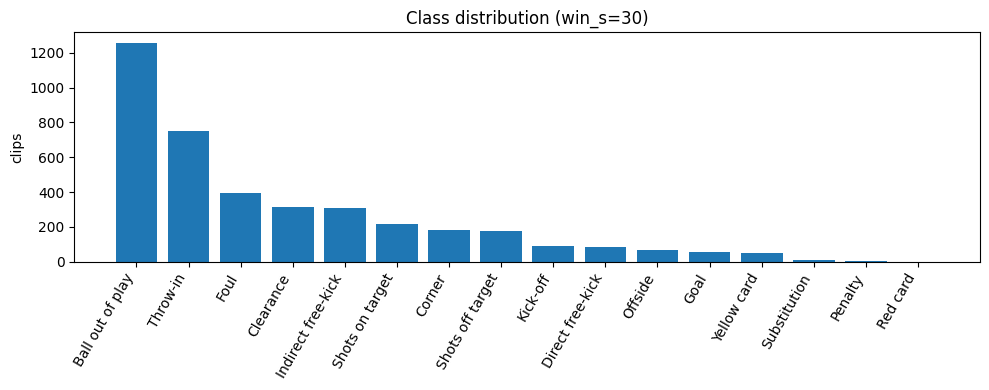

In [88]:
# === Cell 3 (optional): Quick bar chart of class distribution (overall) ===
import matplotlib.pyplot as plt

counts = df_all["event_label"].value_counts().sort_values(ascending=False)
plt.figure(figsize=(10,4))
plt.bar(counts.index, counts.values)
plt.xticks(rotation=60, ha='right')
plt.ylabel("clips")
plt.title(f"Class distribution (win_s={WIN_S})")
plt.tight_layout()
plt.show()

In [89]:
class RNN_Audio(nn.Module):
    """
    Input: [B, 1, n_mels, T] → [B, T, n_mels] → (Linear proj?) → BiGRU → pool → Linear
    """
    def __init__(self, n_mels, n_classes, rnn_hidden=256, rnn_layers=2,
                 proj_dim=None, dropout=0.2, bidirectional=True, use_attention=False):
        super().__init__()
        self.use_attention = use_attention
        in_dim = n_mels
        if proj_dim is not None:
            self.proj = nn.Linear(n_mels, proj_dim)
            in_dim = proj_dim
        else:
            self.proj = None
        self.rnn = nn.GRU(input_size=in_dim, hidden_size=rnn_hidden, num_layers=rnn_layers,
                          batch_first=True, dropout=(dropout if rnn_layers > 1 else 0.0),
                          bidirectional=bidirectional)
        out_dim = rnn_hidden * (2 if bidirectional else 1)
        if use_attention:
            self.attn = nn.Linear(out_dim, 1)
        self.head = nn.Sequential(nn.LayerNorm(out_dim), nn.Dropout(dropout), nn.Linear(out_dim, n_classes))

    def forward(self, x, lengths=None):
        x = x.squeeze(1).transpose(1,2).contiguous()  # [B,T,n_mels]
        if self.proj is not None:
            x = self.proj(x)
        if lengths is not None:
            packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
            y, _ = self.rnn(packed)
            y, _ = nn.utils.rnn.pad_packed_sequence(y, batch_first=True)
        else:
            y, _ = self.rnn(x)
        if self.use_attention:
            a = torch.softmax(self.attn(y).squeeze(-1), dim=1)
            pooled = torch.sum(y * a.unsqueeze(-1), dim=1)
        else:
            pooled = y.mean(dim=1)
        return self.head(pooled)

n_mels = int(train_df.iloc[0]["n_mels"])
model = RNN_Audio(n_mels=n_mels, n_classes=num_classes, rnn_hidden=256, rnn_layers=2,
                  proj_dim=None, dropout=0.2, bidirectional=True, use_attention=False).to(device)
print("Params (M):", sum(p.numel() for p in model.parameters())/1e6)

Params (M): 1.686544


In [90]:
class SmoothCELoss(nn.Module):
    def __init__(self, label_smoothing=0.0, class_weights=None):
        super().__init__()
        self.ls = float(label_smoothing)
        self.register_buffer("w", None if class_weights is None else torch.tensor(class_weights, dtype=torch.float32))
    def forward(self, logits, target):
        if self.ls > 0:
            n = logits.size(-1)
            log_probs = F.log_softmax(logits, dim=-1)
            with torch.no_grad():
                true_dist = torch.full_like(log_probs, self.ls/(n-1))
                true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.ls)
            if self.w is not None:
                weight = self.w[target]
                loss = -(true_dist * log_probs).sum(dim=1) * weight
                return loss.mean()
            return -(true_dist * log_probs).sum(dim=1).mean()
        return F.cross_entropy(logits, target, weight=self.w)

# class weights from train set (inverse frequency)
train_counts = train_df["y"].value_counts().reindex(range(num_classes), fill_value=0).values.astype(np.float32)
class_weights_loss = (train_counts.sum() / (train_counts + 1e-6))
class_weights_loss = class_weights_loss / class_weights_loss.mean()

criterion = SmoothCELoss(label_smoothing=LABEL_SMOOTHING, class_weights=class_weights_loss).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# New AMP API
scaler = torch.amp.GradScaler('cuda', enabled=(USE_MIXED_PREC and device.type=="cuda"))

In [91]:
# === Cell 2: Loss class-weights aligned to new mapping (and recreate criterion) ===
import numpy as np
import torch
import torch.nn.functional as F

# Compute inverse-frequency weights for LOSS (length == num_classes)
train_counts_full = (
    train_df["y"].value_counts()
    .reindex(range(num_classes), fill_value=0)
    .astype(float)
    .values
)
class_weights_loss = (train_counts_full.sum() / (train_counts_full + 1e-6))
class_weights_loss = class_weights_loss / class_weights_loss.mean()

# Recreate your loss to pick up new weights
# (Assumes SmoothCELoss is already defined earlier; if not, run that cell first)
criterion = SmoothCELoss(label_smoothing=LABEL_SMOOTHING,
                         class_weights=class_weights_loss).to(device)

print("Loss class weights shape:", class_weights_loss.shape)


Loss class weights shape: (16,)


In [92]:
# === Cell 3: Build a SAFE sampler (dict-based; no index errors) ===
from torch.utils.data import WeightedRandomSampler
import torch

# Inverse-frequency per class as a dict for the SAMPLER (robust to sparse classes)
inv_freq = (1.0 / (train_df["y"].value_counts() + 1e-6)).to_dict()
sample_weights = train_df["y"].map(lambda yi: float(inv_freq.get(yi, 1.0))).values

sampler = WeightedRandomSampler(
    weights=torch.from_numpy(sample_weights).float(),
    num_samples=len(sample_weights),
    replacement=True,
)

print("Sampler ready. Num samples:", len(sample_weights))


Sampler ready. Num samples: 3172


In [93]:
# === Cell 4: Rebuild DataLoaders with the SAFE dataset/collate ===
# Assumes you already defined SafeMelClipDataset and pad_time_collate_safe earlier.
from torch.utils.data import DataLoader
_mel_tf  = torchaudio.transforms.MelSpectrogram(
    sample_rate=TARGET_SR, n_fft=N_FFT, hop_length=HOP, win_length=N_FFT,
    n_mels=N_MELS, f_min=0.0, f_max=TARGET_SR/2.0, power=2.0, center=True, pad_mode="reflect"
)
_amp2db = torchaudio.transforms.AmplitudeToDB(stype="power")

def _atomic_save_npy(path: Path, arr: np.ndarray):
    path.parent.mkdir(parents=True, exist_ok=True)
    with tempfile.NamedTemporaryFile(delete=False, dir=str(path.parent), suffix=".tmp") as tf:
        tmp = Path(tf.name)
    try:
        np.save(tmp, arr, allow_pickle=False)
        os.replace(tmp, path)  # atomic
    finally:
        try: tmp.unlink()
        except: pass
def _recompute_mel(clip_wav: Path, out_npy: Path) -> bool:
    if not clip_wav.exists():
        return False
    wav, sr = torchaudio.load(str(clip_wav))
    if wav.shape[0] > 1: wav = wav.mean(dim=0, keepdim=True)
    if sr != TARGET_SR:  wav = torchaudio.functional.resample(wav, sr, TARGET_SR)
    with torch.no_grad():
        mel = _mel_tf(wav)                       # [1, n_mels, T]
        mel_db = _amp2db(mel).squeeze(0).cpu().numpy()
        mu, sd = mel_db.mean(), mel_db.std() + 1e-8
        mel_db = (mel_db - mu) / sd
    _atomic_save_npy(Path(out_npy), mel_db)
    return True
class SafeMelClipDataset(Dataset):
    """
    Like your MelClipDataset but robust to corrupt .npy:
    - tries np.load
    - on failure: rebuild from r['audio_wav'] and np.save atomically, then load
    - if still failing: returns None (collate will drop)
    """
    def __init__(self, frame, train=True, aug_freq_masks=0, aug_freq_w=8, aug_time_masks=0, aug_time_w=24):
        self.frame = frame.reset_index(drop=True)
        self.train = train
        self.aug_freq_masks = aug_freq_masks if train else 0
        self.aug_freq_w     = aug_freq_w
        self.aug_time_masks = aug_time_masks if train else 0
        self.aug_time_w     = aug_time_w

    def __len__(self): return len(self.frame)

    def _spec_augment(self, m):
        n_mels, T = m.shape
        out = m.copy()
        import random
        for _ in range(self.aug_freq_masks):
            w = random.randint(1, min(self.aug_freq_w, max(1, n_mels//2)))
            f0 = random.randint(0, max(0, n_mels - w))
            out[f0:f0+w, :] = 0.0
        for _ in range(self.aug_time_masks):
            w = random.randint(1, min(self.aug_time_w, max(1, T//2)))
            t0 = random.randint(0, max(0, T - w))
            out[:, t0:t0+w] = 0.0
        return out

    def _load_or_repair(self, r):
        npy = Path(r["mel_npy"])
        try:
            mel = np.load(npy)  # may raise EOFError for partial files
            if mel.ndim != 2 or mel.shape[0] != N_MELS or mel.shape[1] <= 0:
                raise ValueError("bad shape")
            return mel
        except Exception:
            # attempt rebuild from paired clip (manifest has audio_wav)
            clip = Path(r.get("audio_wav", ""))
            if clip.exists() and _recompute_mel(clip, npy):
                try:
                    mel = np.load(npy)
                    if mel.ndim == 2 and mel.shape[0] == N_MELS and mel.shape[1] > 0:
                        return mel
                except Exception:
                    pass
            return None  # signal failure

    def __getitem__(self, idx):
        r = self.frame.iloc[idx]
        mel = self._load_or_repair(r)
        if mel is None:
            return None  # let collate drop it
        if self.train:
            mel = self._spec_augment(mel)
        x = torch.from_numpy(mel).float().unsqueeze(0)   # [1, n_mels, T]
        y = int(r["y"])
        meta = {"label": r["event_label"], "season": r["season"], "game": r["game"], "t": float(r["t_center_s"])}
        return x, y, meta

def pad_time_collate_safe(batch):
    # filter out failed items
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None  # sentinel -> caller should skip step
    xs, ys, metas = zip(*batch)
    n_mels = xs[0].shape[1]
    lengths = torch.tensor([t.shape[-1] for t in xs], dtype=torch.long)
    T_max = int(lengths.max())
    x_padded = torch.zeros(len(xs), 1, n_mels, T_max, dtype=torch.float32)
    for i, t in enumerate(xs):
        T = t.shape[-1]
        x_padded[i, :, :, :T] = t
    y = torch.tensor(ys, dtype=torch.long)
    return x_padded, y, lengths, metas

# Defaults if not already set
BATCH_SIZE     = int(globals().get("BATCH_SIZE", 16))
AUG_FREQ_MASKS = int(globals().get("AUG_FREQ_MASKS", 1))
AUG_FREQ_WIDTH = int(globals().get("AUG_FREQ_WIDTH", 8))
AUG_TIME_MASKS = int(globals().get("AUG_TIME_MASKS", 1))
AUG_TIME_WIDTH = int(globals().get("AUG_TIME_WIDTH", 24))

NUM_WORKERS = 0                 # keep 0 on Windows; try 2 later when stable
PIN = (device.type == "cuda")   # pin only on CUDA

train_ds = SafeMelClipDataset(
    train_df, train=True,
    aug_freq_masks=AUG_FREQ_MASKS, aug_freq_w=AUG_FREQ_WIDTH,
    aug_time_masks=AUG_TIME_MASKS, aug_time_w=AUG_TIME_WIDTH
)
val_ds = SafeMelClipDataset(val_df, train=False)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, sampler=sampler,
    num_workers=NUM_WORKERS, pin_memory=PIN, persistent_workers=False,
    collate_fn=pad_time_collate_safe
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN, persistent_workers=False,
    collate_fn=pad_time_collate_safe
)

print("Loaders rebuilt:",
      "train batches =", len(train_loader),
      "| val batches =", len(val_loader))


Loaders rebuilt: train batches = 199 | val batches = 50


In [94]:
# === Cell 5: Quick smoke test, then train with your existing loop ===
import time
import torch

# Sanity: one forward pass on a batch to confirm shapes/device
batch = next(iter(train_loader))
while batch is None:  # in case first batch was entirely dropped
    batch = next(iter(train_loader))

x, y, lengths, metas = batch
x = x.to(device, non_blocking=(device.type=="cuda"))
y = y.to(device, non_blocking=(device.type=="cuda"))

with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=(USE_MIXED_PREC and device.type=="cuda")):
    out = model(x, lengths=lengths)

print("Smoke OK — logits:", tuple(out.shape), "| batch:", x.shape, "| lengths[0]:", int(lengths[0]))

# Now run your existing training loop (run_epoch / epochs) exactly as before.


Smoke OK — logits: (16, 16) | batch: torch.Size([16, 1, 64, 1501]) | lengths[0]: 1501


In [95]:
from tqdm import tqdm

def run_epoch(loader, train=True):
    model.train(train)
    total, correct = 0, 0
    y_true, y_pred = [], []
    running_loss = 0.0
    bar = tqdm(loader, total=len(loader), leave=False, desc="train" if train else "valid")
    for x, y, lengths, metas in bar:
        x = x.to(device, non_blocking=(device.type=="cuda"))
        y = y.to(device, non_blocking=(device.type=="cuda"))
        with torch.set_grad_enabled(train):
            with torch.amp.autocast(device_type='cuda', enabled=(USE_MIXED_PREC and device.type=="cuda")):
                logits = model(x, lengths=lengths)
                loss   = criterion(logits, y)
            if train:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
        running_loss += loss.item() * x.size(0)
        pred = logits.detach().softmax(dim=-1).argmax(dim=-1)
        total += x.size(0); correct += (pred == y).sum().item()
        y_true.extend(y.cpu().tolist()); y_pred.extend(pred.cpu().tolist())
        bar.set_postfix(loss=running_loss/max(1,total), acc=correct/max(1,total))
    epoch_loss = running_loss / max(1, total)
    acc = correct / max(1, total)
    f1m = f1_score(y_true, y_pred, average="macro", zero_division=0)
    return epoch_loss, acc, f1m, (y_true, y_pred)

# Smoke test to confirm GPU path works
xb, yb, lengths, _ = next(iter(train_loader))
xb = xb.to(device, non_blocking=(device.type=="cuda"))
with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=(USE_MIXED_PREC and device.type=="cuda")):
    _ = model(xb, lengths=lengths)
print("Smoke test OK (forward pass).")

best_f1 = 0.0
best_path = WORK_DIR / f"rnn_baseline_win{WIN_S}s.pt"

for epoch in range(1, NUM_EPOCHS+1):
    tr_loss, tr_acc, tr_f1, _        = run_epoch(train_loader, train=True)
    va_loss, va_acc, va_f1, (vy, vp) = run_epoch(val_loader,   train=False)
    scheduler.step()
    if va_f1 > best_f1:
        best_f1 = va_f1
        torch.save({"model": model.state_dict(),
                    "labels_sorted": labels_sorted,
                    "cfg": {"win_s": WIN_S, "n_mels": n_mels}}, best_path)
    print(f"[{epoch:02d}/{NUM_EPOCHS}] "
          f"train: loss={tr_loss:.4f} acc={tr_acc:.3f} f1={tr_f1:.3f} | "
          f"val: loss={va_loss:.4f} acc={va_acc:.3f} f1={va_f1:.3f} | best_f1={best_f1:.3f}")

print("Saved best →", best_path)
print(classification_report(vy, vp, target_names=[id_to_label[i] for i in range(num_classes)],
                            digits=3, zero_division=0))

Smoke test OK (forward pass).


[01/20] train: loss=0.0000 acc=0.130 f1=0.047 | val: loss=0.1160 acc=0.011 f1=0.040 | best_f1=0.040


[02/20] train: loss=0.0000 acc=0.166 f1=0.080 | val: loss=0.1185 acc=0.015 f1=0.052 | best_f1=0.052


[03/20] train: loss=0.0000 acc=0.184 f1=0.094 | val: loss=0.1247 acc=0.015 f1=0.050 | best_f1=0.052


[04/20] train: loss=0.0000 acc=0.198 f1=0.104 | val: loss=0.1179 acc=0.019 f1=0.044 | best_f1=0.052


[05/20] train: loss=0.0000 acc=0.200 f1=0.113 | val: loss=0.1200 acc=0.018 f1=0.058 | best_f1=0.058


[06/20] train: loss=0.0000 acc=0.204 f1=0.117 | val: loss=0.1246 acc=0.019 f1=0.055 | best_f1=0.058


[07/20] train: loss=0.0000 acc=0.185 f1=0.107 | val: loss=0.0978 acc=0.018 f1=0.047 | best_f1=0.058


[08/20] train: loss=0.0000 acc=0.197 f1=0.113 | val: loss=0.1076 acc=0.023 f1=0.052 | best_f1=0.058


[09/20] train: loss=0.0000 acc=0.201 f1=0.118 | val: loss=0.1117 acc=0.020 f1=0.051 | best_f1=0.058


[10/20] train: loss=0.0000 acc=0.209 f1=0.116 | val: loss=0.1014 acc=0.020 f1=0.050 | best_f1=0.058


[11/20] train: loss=0.0000 acc=0.215 f1=0.128 | val: loss=0.1111 acc=0.021 f1=0.052 | best_f1=0.058


[12/20] train: loss=0.0000 acc=0.214 f1=0.129 | val: loss=0.1076 acc=0.023 f1=0.053 | best_f1=0.058


[13/20] train: loss=0.0000 acc=0.206 f1=0.125 | val: loss=0.1141 acc=0.021 f1=0.047 | best_f1=0.058


[14/20] train: loss=0.0000 acc=0.229 f1=0.138 | val: loss=0.1132 acc=0.020 f1=0.044 | best_f1=0.058


[15/20] train: loss=0.0000 acc=0.218 f1=0.134 | val: loss=0.1192 acc=0.023 f1=0.049 | best_f1=0.058


[16/20] train: loss=0.0000 acc=0.220 f1=0.135 | val: loss=0.1147 acc=0.020 f1=0.053 | best_f1=0.058


[17/20] train: loss=0.0000 acc=0.235 f1=0.141 | val: loss=0.1146 acc=0.024 f1=0.058 | best_f1=0.058


[18/20] train: loss=0.0000 acc=0.234 f1=0.138 | val: loss=0.1102 acc=0.023 f1=0.049 | best_f1=0.058


[19/20] train: loss=0.0000 acc=0.223 f1=0.134 | val: loss=0.1120 acc=0.023 f1=0.050 | best_f1=0.058


[20/20] train: loss=0.0000 acc=0.217 f1=0.136 | val: loss=0.1113 acc=0.023 f1=0.050 | best_f1=0.058
Saved best → sn_audio_work\rnn_baseline_win30s.pt
                    precision    recall  f1-score   support

  Ball out of play      0.000     0.000     0.000       266
         Clearance      0.000     0.000     0.000        89
            Corner      0.000     0.000     0.000        36
  Direct free-kick      0.000     0.000     0.000        13
              Foul      0.000     0.000     0.000        74
              Goal      0.086     0.625     0.152         8
Indirect free-kick      0.000     0.000     0.000        66
          Kick-off      0.600     0.600     0.600        15
           Offside      0.016     0.182     0.029        11
           Penalty      0.008     1.000     0.016         1
          Red card      0.000     0.000     0.000         1
  Shots off target      0.000     0.000     0.000        41
   Shots on target      0.000     0.000     0.000        38
      Sub

**Addressing Class Imbalance with Kmeans**

In [96]:
# === Filter manifest to top-K classes and re-split ===
K = 6  # try 5–8
WIN_S = int(globals().get("WIN_S", 30))
from pathlib import Path
import pandas as pd, random

WORK_DIR  = Path("./sn_audio_work")
INDEX_CSV = WORK_DIR / "dataset_index.csv"

df_all = pd.read_csv(INDEX_CSV)
df_all = df_all[(df_all["win_s"]==WIN_S) & (df_all["mel_npy"].apply(lambda p: Path(p).exists()))].copy()

topK = df_all["event_label"].value_counts().nlargest(K).index.tolist()
dfK  = df_all[df_all["event_label"].isin(topK)].reset_index(drop=True)

dfK["game_key"] = dfK["season"].astype(str) + "/" + dfK["game"].astype(str)
games = dfK["game_key"].unique().tolist()
random.shuffle(games)
n_train = int(0.8 * len(games))
train_games = set(games[:n_train]); val_games = set(games[n_train:])

train_df = dfK[dfK["game_key"].isin(train_games)].reset_index(drop=True)
val_df   = dfK[dfK["game_key"].isin(val_games)].reset_index(drop=True)

print("Top-K classes:", topK)
print("Train/Val clips:", len(train_df), len(val_df))


Top-K classes: ['Ball out of play', 'Throw-in', 'Foul', 'Clearance', 'Indirect free-kick', 'Shots on target']
Train/Val clips: 2547 692


In [97]:
# === Waveform dataset for pretrained backbone ===
import torch, torchaudio, numpy as np
from torch.utils.data import Dataset

TARGET_SR = int(globals().get("TARGET_SR", 16000))

class WavClipDataset(Dataset):
    def __init__(self, frame):
        self.frame = frame.reset_index(drop=True)
    def __len__(self): return len(self.frame)
    def __getitem__(self, idx):
        r = self.frame.iloc[idx]
        wav, sr = torchaudio.load(str(r["audio_wav"]))
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)      # mono
        if sr != TARGET_SR:
            wav = torchaudio.functional.resample(wav, sr, TARGET_SR)
        y = int(r["y"])
        meta = {"label": r["event_label"], "season": r["season"], "game": r["game"], "t": float(r["t_center_s"])}
        return wav.squeeze(0), y, meta  # [T], int, meta

def pad_wave_collate(batch):
    xs, ys, metas = zip(*batch)
    lengths = torch.tensor([x.numel() for x in xs], dtype=torch.long)
    T_max = int(lengths.max())
    xpad = torch.zeros(len(xs), T_max, dtype=torch.float32)
    for i, x in enumerate(xs):
        T = x.numel()
        xpad[i, :T] = x
    y = torch.tensor(ys, dtype=torch.long)
    return xpad, y, lengths, metas


In [98]:
# === Pretrained backbone (wav2vec2) + small head ===
import torch.nn as nn
import torchaudio

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bundle = torchaudio.pipelines.WAV2VEC2_BASE  # 768-d features, expects 16kHz
w2v = bundle.get_model().to(device)
for p in w2v.parameters():
    p.requires_grad = False
w2v.eval()

feat_dim = 768  # for WAV2VEC2_BASE

class W2VHead(nn.Module):
    """Encodes waveform with wav2vec2; mean-pools frames; classifies."""
    def __init__(self, n_classes, p_drop=0.2):
        super().__init__()
        self.norm = nn.LayerNorm(feat_dim)
        self.drop = nn.Dropout(p_drop)
        self.fc   = nn.Linear(feat_dim, n_classes)
    @torch.no_grad()
    def encode(self, wav_batch, lengths=None):
        # wav_batch: [B, T] float32, 16kHz
        # wav2vec2 expects [B, T]; it returns [B, T', 768]
        feats, _ = w2v.extract_features(wav_batch.to(device))  # list of layers; take last
        x = feats[-1]  # [B, T', 768]
        return x
    def forward(self, wav_batch, lengths=None):
        with torch.no_grad():
            x = self.encode(wav_batch, lengths)  # [B, T', 768]
        x = x.mean(dim=1)                        # mean-pool over time -> [B, 768]
        x = self.drop(self.norm(x))
        return self.fc(x)

# Rebuild label mapping to match your current train_df/val_df
import pandas as pd
labels_sorted = sorted(pd.concat([train_df["event_label"], val_df["event_label"]]).unique())
label_to_id   = {lab:i for i, lab in enumerate(labels_sorted)}
id_to_label   = {i:lab for lab,i in label_to_id.items()}
num_classes   = len(labels_sorted)
train_df["y"] = train_df["event_label"].map(label_to_id).astype(int)
val_df["y"]   = val_df["event_label"].map(label_to_id).astype(int)

model = W2VHead(n_classes=num_classes).to(device)
print("Classes:", num_classes)


Classes: 6


In [99]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch

BATCH_SIZE = int(globals().get("BATCH_SIZE", 16))
NUM_WORKERS = 0
PIN = (device.type == "cuda")

train_wav_ds = WavClipDataset(train_df)
val_wav_ds   = WavClipDataset(val_df)

# Sampler (inverse freq)
inv_freq = (1.0 / (train_df["y"].value_counts() + 1e-6)).to_dict()
sample_weights = train_df["y"].map(lambda yi: float(inv_freq.get(yi, 1.0))).values
sampler = WeightedRandomSampler(weights=torch.from_numpy(sample_weights).float(),
                                num_samples=len(sample_weights),
                                replacement=True)

train_wav_loader = DataLoader(train_wav_ds, batch_size=BATCH_SIZE, sampler=sampler,
                              num_workers=NUM_WORKERS, pin_memory=PIN, collate_fn=pad_wave_collate)
val_wav_loader   = DataLoader(val_wav_ds, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=PIN, collate_fn=pad_wave_collate)

print("Waveform loaders:", len(train_wav_loader), len(val_wav_loader))


Waveform loaders: 160 44


In [100]:
import torch.nn.functional as F
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scaler    = torch.amp.GradScaler('cuda', enabled=(device.type=="cuda"))
EPOCHS    = 15

def run_epoch_wav(loader, train=True):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    ys, ps = [], []
    pbar = tqdm(loader, leave=False, desc="train" if train else "valid")
    for wav, y, lengths, metas in pbar:
        wav = wav.to(device, non_blocking=(device.type=="cuda"))
        y   = y.to(device, non_blocking=(device.type=="cuda"))
        with torch.set_grad_enabled(train):
            with torch.amp.autocast(device_type='cuda', enabled=(device.type=="cuda")):
                logits = model(wav, lengths=lengths)
                loss   = F.cross_entropy(logits, y)
            if train:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
        loss_sum += float(loss.item()) * wav.size(0)
        pred = logits.detach().softmax(dim=-1).argmax(dim=-1)
        total += wav.size(0); correct += (pred==y).sum().item()
        ys += y.cpu().tolist(); ps += pred.cpu().tolist()
        pbar.set_postfix(loss=loss_sum/max(1,total), acc=correct/max(1,total))
    return loss_sum/max(1,total), correct/max(1,total), f1_score(ys, ps, average="macro", zero_division=0), (ys, ps)

best_f1 = 0.0
for e in range(1, EPOCHS+1):
    tr = run_epoch_wav(train_wav_loader, train=True)
    va = run_epoch_wav(val_wav_loader,   train=False)
    print(f"[{e:02d}/{EPOCHS}] train: loss={tr[0]:.4f} acc={tr[1]:.3f} f1={tr[2]:.3f} | "
          f"val: loss={va[0]:.4f} acc={va[1]:.3f} f1={va[2]:.3f}")
    if va[2] > best_f1:
        best_f1 = va[2]
        torch.save({"head": model.state_dict(),
                    "labels_sorted": labels_sorted},
                   WORK_DIR / f"w2v_head_win{WIN_S}s.pt")

print("Best F1:", best_f1)
print(classification_report(va[3][0], va[3][1], target_names=[id_to_label[i] for i in range(num_classes)], digits=3, zero_division=0))


[01/15] train: loss=1.8032 acc=0.228 f1=0.227 | val: loss=1.9712 acc=0.149 f1=0.136


[02/15] train: loss=1.7422 acc=0.262 f1=0.252 | val: loss=1.8816 acc=0.184 f1=0.160


[03/15] train: loss=1.6736 acc=0.289 f1=0.286 | val: loss=1.7006 acc=0.262 f1=0.180


[04/15] train: loss=1.6600 acc=0.318 f1=0.312 | val: loss=1.7479 acc=0.201 f1=0.160


[05/15] train: loss=1.6539 acc=0.314 f1=0.304 | val: loss=1.9473 acc=0.156 f1=0.159


[06/15] train: loss=1.6244 acc=0.340 f1=0.328 | val: loss=1.8225 acc=0.191 f1=0.196


[07/15] train: loss=1.6072 acc=0.341 f1=0.330 | val: loss=1.7314 acc=0.247 f1=0.186


[08/15] train: loss=1.6033 acc=0.336 f1=0.333 | val: loss=1.8375 acc=0.186 f1=0.188


[09/15] train: loss=1.6144 acc=0.336 f1=0.323 | val: loss=1.6703 acc=0.251 f1=0.225


[10/15] train: loss=1.5740 acc=0.360 f1=0.355 | val: loss=1.7300 acc=0.228 f1=0.229


[11/15] train: loss=1.5665 acc=0.362 f1=0.355 | val: loss=1.7377 acc=0.217 f1=0.189


[12/15] train: loss=1.5461 acc=0.364 f1=0.358 | val: loss=1.7819 acc=0.210 f1=0.188


[13/15] train: loss=1.5446 acc=0.370 f1=0.364 | val: loss=1.7254 acc=0.223 f1=0.222


[14/15] train: loss=1.5544 acc=0.373 f1=0.362 | val: loss=1.7425 acc=0.277 f1=0.256


[15/15] train: loss=1.5673 acc=0.361 f1=0.349 | val: loss=1.7616 acc=0.225 f1=0.219
Best F1: 0.25569697302648026
                    precision    recall  f1-score   support

  Ball out of play      0.333     0.012     0.022       258
         Clearance      0.190     0.393     0.257        61
              Foul      0.202     0.264     0.229        87
Indirect free-kick      0.095     0.145     0.115        76
   Shots on target      0.290     0.383     0.330        47
          Throw-in      0.291     0.472     0.360       163

          accuracy                          0.225       692
         macro avg      0.234     0.278     0.219       692
      weighted avg      0.265     0.225     0.180       692



In [101]:
# === Shared: waveform dataset, collate, and a generic trainer ===
import torch, torchaudio, numpy as np
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class WavClipDataset(Dataset):
    """
    Returns center-cropped / padded waveforms at the model's target SR and target seconds.
    """
    def __init__(self, frame, target_sr=16000, target_seconds=10.0):
        self.frame = frame.reset_index(drop=True)
        self.target_sr = int(target_sr)
        self.target_len = int(round(target_seconds * self.target_sr))

    def __len__(self): return len(self.frame)

    def _center_crop_pad(self, wav):
        T = wav.numel()
        if T == self.target_len:
            return wav
        if T > self.target_len:
            start = (T - self.target_len) // 2
            return wav[start:start+self.target_len]
        # pad
        out = torch.zeros(self.target_len, dtype=wav.dtype)
        out[:T] = wav
        return out

    def __getitem__(self, idx):
        r = self.frame.iloc[idx]
        wav, sr = torchaudio.load(str(r["audio_wav"]))
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)
        if sr != self.target_sr:
            wav = torchaudio.functional.resample(wav, orig_freq=sr, new_freq=self.target_sr)
        wav = wav.squeeze(0)
        wav = self._center_crop_pad(wav)
        y = int(r["y"])
        return wav, y, {"label": r["event_label"], "season": r["season"], "game": r["game"]}

def pad_wave_collate(batch):
    xs, ys, metas = zip(*batch)
    lengths = torch.tensor([x.numel() for x in xs], dtype=torch.long)
    T_max = int(lengths.max())
    xpad = torch.zeros(len(xs), T_max, dtype=torch.float32)
    for i, x in enumerate(xs):
        xpad[i, :x.numel()] = x
    return xpad, torch.tensor(ys, dtype=torch.long), lengths, metas

def make_sampler(frame):
    inv_freq = (1.0 / (frame["y"].value_counts() + 1e-6)).to_dict()
    w = frame["y"].map(lambda yi: float(inv_freq.get(yi, 1.0))).values
    return WeightedRandomSampler(weights=torch.from_numpy(w).float(),
                                 num_samples=len(w), replacement=True)

@torch.no_grad()
def evaluate_wave(model, loader, id_to_label):
    model.eval()
    tot, correct, loss_sum = 0, 0, 0.0
    ys, ps = [], []
    for wav, y, lengths, _ in loader:
        wav = wav.to(device, non_blocking=(device.type=="cuda"))
        y   = y.to(device, non_blocking=(device.type=="cuda"))
        logits, loss = model.loss_on_batch(wav, y, lengths)
        pred = logits.softmax(dim=-1).argmax(dim=-1)
        tot += wav.size(0); correct += (pred==y).sum().item()
        loss_sum += float(loss.item()) * wav.size(0)
        ys += y.cpu().tolist(); ps += pred.cpu().tolist()
    acc = correct / max(1, tot)
    f1m = f1_score(ys, ps, average="macro", zero_division=0)
    print(f"val: loss={loss_sum/max(1,tot):.4f} acc={acc:.3f} f1={f1m:.3f}")
    print(classification_report(ys, ps, target_names=[id_to_label[i] for i in range(len(id_to_label))],
                                digits=3, zero_division=0))
    return f1m

def train_wave(model, train_loader, val_loader, id_to_label, epochs=5, lr=1e-3, wd=1e-4):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scaler = torch.amp.GradScaler('cuda', enabled=(device.type=='cuda'))
    best = 0.0
    for e in range(1, epochs+1):
        model.train()
        tot, correct, loss_sum = 0, 0, 0.0
        pbar = tqdm(train_loader, desc=f"train[{e}/{epochs}]", leave=False)
        for wav, y, lengths, _ in pbar:
            wav = wav.to(device, non_blocking=(device.type=="cuda"))
            y   = y.to(device, non_blocking=(device.type=="cuda"))
            with torch.amp.autocast(device_type='cuda', enabled=(device.type=='cuda')):
                logits, loss = model.loss_on_batch(wav, y, lengths)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            opt.zero_grad(set_to_none=True)
            loss_sum += float(loss.item()) * wav.size(0)
            pred = logits.detach().softmax(dim=-1).argmax(dim=-1)
            tot += wav.size(0); correct += (pred==y).sum().item()
            pbar.set_postfix(loss=loss_sum/max(1,tot), acc=correct/max(1,tot))
        print(f"train: loss={loss_sum/max(1,tot):.4f} acc={correct/max(1,tot):.3f}")
        f1m = evaluate_wave(model, val_loader, id_to_label)
        best = max(best, f1m)
    print("Best macro-F1:", best)


In [102]:
# If needed:
%pip install --quiet transformers timm --user
%pip install --user --upgrade --force-reinstall "numpy==1.26.4"

import torch, torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoFeatureExtractor, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ast_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
ast_fe   = AutoFeatureExtractor.from_pretrained(ast_name)
ast_backbone = AutoModel.from_pretrained(ast_name).to(device).eval()
for p in ast_backbone.parameters():
    p.requires_grad = False

hidden_dim = ast_backbone.config.hidden_size  # typically 768

class ASTHead(nn.Module):
    def __init__(self, n_classes, dropout=0.2):
        super().__init__()
        self.norm = nn.LayerNorm(hidden_dim)
        self.drop = nn.Dropout(dropout)
        self.fc   = nn.Linear(hidden_dim, n_classes)
        self.ce   = nn.CrossEntropyLoss()
        self.to(device)

    @torch.no_grad()
    def encode(self, wav16k):
        # wav16k: [B, T] float32 at 16kHz
        wav_list = [w.cpu().numpy() for w in wav16k]
        inputs = ast_fe(wav_list, sampling_rate=16000, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        out = ast_backbone(**inputs)          # last_hidden_state: [B, L, D]
        return out.last_hidden_state

    def forward(self, wav16k, lengths=None):
        h = self.encode(wav16k)               # [B, L, D]
        pooled = h.mean(dim=1)                # [B, D]
        return self.fc(self.drop(self.norm(pooled)))

    def loss_on_batch(self, wav16k, y, lengths=None):
        logits = self.forward(wav16k, lengths)
        loss = self.ce(logits, y)
        return logits, loss

# 10s, 16kHz crops (AST was finetuned on 10s segments)
train_ds = WavClipDataset(train_df, target_sr=16000, target_seconds=10.0)
val_ds   = WavClipDataset(val_df,   target_sr=16000, target_seconds=10.0)

sampler  = make_sampler(train_df)
train_loader = DataLoader(train_ds, batch_size=8, sampler=sampler, num_workers=0,
                          pin_memory=(device.type=='cuda'), collate_fn=pad_wave_collate)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=0,
                          pin_memory=(device.type=='cuda'), collate_fn=pad_wave_collate)

ast_model = ASTHead(n_classes=len(id_to_label))
print("AST head params (M):", sum(p.numel() for p in ast_model.parameters())/1e6)

# Train a few epochs with your shared trainer
train_wave(ast_model, train_loader, val_loader, id_to_label, epochs=10, lr=1e-3, wd=1e-4)


Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.4
    Uninstalling numpy-2.3.4:
      Successfully uninstalled numpy-2.3.4
Note: you may need to restart the kernel to use updated packages.
AST head params (M): 0.00615


train: loss=1.6120 acc=0.327
val: loss=1.7303 acc=0.244 f1=0.236
                    precision    recall  f1-score   support

  Ball out of play      0.535     0.178     0.267       258
         Clearance      0.274     0.705     0.394        61
              Foul      0.483     0.322     0.386        87
Indirect free-kick      0.333     0.092     0.144        76
   Shots on target      0.119     0.936     0.212        47
          Throw-in      1.000     0.006     0.012       163

          accuracy                          0.244       692
         macro avg      0.457     0.373     0.236       692
      weighted avg      0.565     0.244     0.216       692



train: loss=1.4322 acc=0.422
val: loss=1.3574 acc=0.464 f1=0.373
                    precision    recall  f1-score   support

  Ball out of play      0.526     0.674     0.591       258
         Clearance      0.371     0.213     0.271        61
              Foul      0.529     0.310     0.391        87
Indirect free-kick      0.500     0.118     0.191        76
   Shots on target      0.362     0.362     0.362        47
          Throw-in      0.386     0.497     0.434       163

          accuracy                          0.464       692
         macro avg      0.446     0.362     0.373       692
      weighted avg      0.466     0.464     0.441       692



train: loss=1.3250 acc=0.471
val: loss=1.4160 acc=0.392 f1=0.390
                    precision    recall  f1-score   support

  Ball out of play      0.671     0.380     0.485       258
         Clearance      0.163     0.492     0.245        61
              Foul      0.573     0.540     0.556        87
Indirect free-kick      0.227     0.382     0.284        76
   Shots on target      0.386     0.468     0.423        47
          Throw-in      0.474     0.276     0.349       163

          accuracy                          0.392       692
         macro avg      0.416     0.423     0.390       692
      weighted avg      0.499     0.392     0.415       692



train: loss=1.2804 acc=0.494
val: loss=1.4711 acc=0.377 f1=0.355
                    precision    recall  f1-score   support

  Ball out of play      0.694     0.388     0.498       258
         Clearance      0.421     0.262     0.323        61
              Foul      0.500     0.598     0.545        87
Indirect free-kick      0.208     0.697     0.320        76
   Shots on target      0.148     0.404     0.217        47
          Throw-in      0.913     0.129     0.226       163

          accuracy                          0.377       692
         macro avg      0.481     0.413     0.355       692
      weighted avg      0.607     0.377     0.386       692



train: loss=1.2652 acc=0.476
val: loss=1.4230 acc=0.418 f1=0.411
                    precision    recall  f1-score   support

  Ball out of play      0.769     0.349     0.480       258
         Clearance      0.297     0.492     0.370        61
              Foul      0.575     0.575     0.575        87
Indirect free-kick      0.277     0.368     0.316        76
   Shots on target      0.210     0.787     0.332        47
          Throw-in      0.491     0.331     0.396       163

          accuracy                          0.418       692
         macro avg      0.437     0.484     0.411       692
      weighted avg      0.546     0.418     0.434       692



train: loss=1.2235 acc=0.519
val: loss=1.3617 acc=0.445 f1=0.435
                    precision    recall  f1-score   support

  Ball out of play      0.569     0.399     0.469       258
         Clearance      0.415     0.279     0.333        61
              Foul      0.466     0.701     0.560        87
Indirect free-kick      0.250     0.447     0.321        76
   Shots on target      0.390     0.681     0.496        47
          Throw-in      0.504     0.374     0.430       163

          accuracy                          0.445       692
         macro avg      0.432     0.480     0.435       692
      weighted avg      0.480     0.445     0.445       692



train: loss=1.1841 acc=0.543
val: loss=1.4274 acc=0.395 f1=0.381
                    precision    recall  f1-score   support

  Ball out of play      0.766     0.368     0.497       258
         Clearance      0.349     0.246     0.288        61
              Foul      0.313     0.655     0.424        87
Indirect free-kick      0.205     0.526     0.295        76
   Shots on target      0.363     0.702     0.478        47
          Throw-in      0.579     0.202     0.300       163

          accuracy                          0.395       692
         macro avg      0.429     0.450     0.381       692
      weighted avg      0.539     0.395     0.400       692



train: loss=1.1740 acc=0.540
val: loss=1.4465 acc=0.448 f1=0.431
                    precision    recall  f1-score   support

  Ball out of play      0.787     0.388     0.519       258
         Clearance      0.311     0.525     0.390        61
              Foul      0.612     0.690     0.649        87
Indirect free-kick      0.290     0.263     0.276        76
   Shots on target      0.205     0.681     0.315        47
          Throw-in      0.475     0.405     0.437       163

          accuracy                          0.448       692
         macro avg      0.447     0.492     0.431       692
      weighted avg      0.556     0.448     0.464       692



train: loss=1.1411 acc=0.552
val: loss=1.3827 acc=0.464 f1=0.453
                    precision    recall  f1-score   support

  Ball out of play      0.596     0.457     0.518       258
         Clearance      0.342     0.443     0.386        61
              Foul      0.630     0.529     0.575        87
Indirect free-kick      0.261     0.395     0.314        76
   Shots on target      0.343     0.766     0.474        47
          Throw-in      0.525     0.393     0.449       163

          accuracy                          0.464       692
         macro avg      0.449     0.497     0.453       692
      weighted avg      0.507     0.464     0.472       692



train: loss=1.1354 acc=0.557
val: loss=1.4398 acc=0.421 f1=0.405
                    precision    recall  f1-score   support

  Ball out of play      0.743     0.314     0.441       258
         Clearance      0.350     0.459     0.397        61
              Foul      0.286     0.874     0.431        87
Indirect free-kick      0.306     0.342     0.323        76
   Shots on target      0.538     0.298     0.384        47
          Throw-in      0.524     0.405     0.457       163

          accuracy                          0.421       692
         macro avg      0.458     0.449     0.405       692
      weighted avg      0.537     0.421     0.423       692

Best macro-F1: 0.45253354809361973


In [103]:
# === AST (CLS pooling) + partial fine-tuning of top 2 blocks ===
import torch, torch.nn as nn
from transformers import AutoFeatureExtractor, AutoModel
from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ast_name = "MIT/ast-finetuned-audioset-10-10-0.4593"

ast_fe   = AutoFeatureExtractor.from_pretrained(ast_name)
ast_backbone = AutoModel.from_pretrained(ast_name).to(device)
hidden_dim = ast_backbone.config.hidden_size  # ~768

# Freeze everything, then unfreeze last 2 encoder blocks
for p in ast_backbone.parameters():
    p.requires_grad = False

encoder = ast_backbone.encoder if hasattr(ast_backbone, "encoder") else ast_backbone
# Works for AST’s Wav2Vec2-like encoder layout
last_blocks = []
if hasattr(encoder, "layer"):
    # HuggingFace naming
    last_blocks = encoder.layer[-2:]  # last 2 blocks
elif hasattr(encoder, "layers"):
    last_blocks = encoder.layers[-2:]
for blk in last_blocks:
    for p in blk.parameters():
        p.requires_grad = True

# small head on CLS
class ASTHeadCLS(nn.Module):
    def __init__(self, backbone, n_classes, dropout=0.2):
        super().__init__()
        self.backbone = backbone
        self.norm = nn.LayerNorm(hidden_dim)
        self.drop = nn.Dropout(dropout)
        self.fc   = nn.Linear(hidden_dim, n_classes)
        self.ce   = nn.CrossEntropyLoss()
        self.to(device)

    def forward(self, wav16k, lengths=None):
        # Extract features
        wav_list = [w.cpu().numpy() for w in wav16k]
        inputs = ast_fe(wav_list, sampling_rate=16000, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        out = self.backbone(**inputs)              # last_hidden_state [B, L, D]
        h  = out.last_hidden_state
        cls = h[:, 0]                              # CLS token pooling
        logits = self.fc(self.drop(self.norm(cls)))
        return logits

    def loss_on_batch(self, wav16k, y, lengths=None):
        logits = self.forward(wav16k, lengths)
        loss = self.ce(logits, y)
        return logits, loss

ast_model = ASTHeadCLS(ast_backbone, n_classes=len(id_to_label)).to(device)

# Optimizer with lower LR for backbone, higher for head
head_params = list(ast_model.fc.parameters()) + list(ast_model.norm.parameters())
ft_params   = []
for blk in last_blocks:
    ft_params += list(blk.parameters())

optim = AdamW([
    {"params": head_params, "lr": 3e-4, "weight_decay": 1e-4},
    {"params": ft_params,   "lr": 3e-5, "weight_decay": 1e-4},  # 10x lower
])

# Plug into your train loop by overriding the optimizer used there, e.g.:
# (if your train code constructs optimizer inside a function, pass this one in or adapt)
optimizer = optim


In [104]:
# 15s crops, random start jitter ±2s (implement in your WavClipDataset if not present)
train_ds = WavClipDataset(train_df, target_sr=16000, target_seconds=15.0)
val_ds   = WavClipDataset(val_df,   target_sr=16000, target_seconds=15.0)

from torch.utils.data import DataLoader
sampler  = make_sampler(train_df)
train_loader = DataLoader(train_ds, batch_size=8, sampler=sampler, num_workers=0,
                          pin_memory=(device.type=='cuda'), collate_fn=pad_wave_collate)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=0,
                          pin_memory=(device.type=='cuda'), collate_fn=pad_wave_collate)


In [105]:
# === Patch: FocalLoss with device-safe class weights, then rebind into AST model ===
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super().__init__()
        self.gamma = float(gamma)
        # register as buffer so it moves with .to(device)
        if alpha is None:
            self.register_buffer("alpha", None)
        else:
            self.register_buffer("alpha", torch.as_tensor(alpha, dtype=torch.float32))

    def forward(self, logits, target):
        # Cross-entropy per-sample with optional class weights
        ce = nn.functional.cross_entropy(logits, target, reduction="none", weight=self.alpha)
        # pt = prob of the true class (detach not needed here)
        pt = torch.softmax(logits, dim=-1)[torch.arange(target.size(0), device=logits.device), target]
        return (((1.0 - pt) ** self.gamma) * ce).mean()

# --- Rebuild alpha on CPU, then .to(device) via module.to(device)
labels = sorted(set(train_df["y"].tolist()))
num_classes = len(labels)

counts = train_df["y"].value_counts().reindex(range(num_classes), fill_value=0).values.astype("float32")
alpha  = (counts.sum() / (counts + 1e-6))
alpha  = (alpha / alpha.mean()).tolist()

criterion = FocalLoss(gamma=2.0, alpha=alpha).to(device)

# If you already built ast_model, just swap its loss_fn and make sure it's on device
ast_model.loss_fn = criterion
ast_model.to(device)

print("FocalLoss alpha device:", "None" if criterion.alpha is None else criterion.alpha.device)


FocalLoss alpha device: cuda:0


**AST**

In [106]:
# --- Re-canonize labels across the union of train+val and remap y ---
import numpy as np
import pandas as pd

# df should be your full index; rebuild train/val split if needed
# (If you already have train_df/val_df, we’ll recompute mappings from both.)
all_df = pd.concat([train_df, val_df], ignore_index=True)

labels_sorted = sorted(all_df["event_label"].unique())
label_to_id   = {lab:i for i, lab in enumerate(labels_sorted)}
id_to_label   = {i:lab for lab,i in label_to_id.items()}
num_classes   = len(labels_sorted)
print("num_classes:", num_classes)

# Remap y consistently
train_df = train_df.copy()
val_df   = val_df.copy()
train_df["y"] = train_df["event_label"].map(label_to_id)
val_df["y"]   = val_df["event_label"].map(label_to_id)

assert train_df["y"].between(0, num_classes-1).all(), "Train has out-of-range ids"
assert val_df["y"].between(0, num_classes-1).all(),   "Val has out-of-range ids"

# (Optional) show counts
print("Train counts:\n", train_df["y"].value_counts().sort_index())
print("Val counts:\n",   val_df["y"].value_counts().sort_index())


num_classes: 6
Train counts:
 y
0    996
1    251
2    308
3    234
4    170
5    588
Name: count, dtype: int64
Val counts:
 y
0    258
1     61
2     87
3     76
4     47
5    163
Name: count, dtype: int64


In [107]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch

# Rebuild datasets with your Safe/Wav datasets (adjust class names if you use SafeMelClipDataset etc.)
HAS_JITTER = "random_jitter_seconds" in WavClipDataset.__init__.__code__.co_varnames
train_ds = (WavClipDataset(train_df, target_sr=16000, target_seconds=15.0,
                           random_jitter_seconds=2.0) if HAS_JITTER
           else WavClipDataset(train_df, target_sr=16000, target_seconds=15.0))
val_ds   = WavClipDataset(val_df,   target_sr=16000, target_seconds=15.0)

# Weighted sampler (now consistent with canonical num_classes)
class_counts = train_df["y"].value_counts().reindex(range(num_classes), fill_value=0).values.astype("float32")
class_weights = 1.0 / (class_counts + 1e-6)
sample_weights = train_df["y"].map(lambda yi: class_weights[int(yi)]).values

sampler = WeightedRandomSampler(
    weights=torch.from_numpy(sample_weights).float(),
    num_samples=len(sample_weights),
    replacement=True
)

PIN = (torch.cuda.is_available())
BATCH_SIZE = 8

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=0, pin_memory=PIN, collate_fn=pad_wave_collate)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=PIN, collate_fn=pad_wave_collate)

print("Loaders rebuilt.")


Loaders rebuilt.


In [108]:
import torch, os
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
# Detect if CUDA is in a bad state (after a prior device-side assert)
try:
    if torch.cuda.is_available():
        torch.ones(1, device="cuda").sum().item()
        print("CUDA quick test: OK")
except Exception as e:
    print("CUDA quick test FAILED:", e)
    print(">>> Please Restart the Jupyter kernel (the CUDA context is poisoned by a prior assert).")


Device: cuda
CUDA quick test: OK


In [109]:
# Make sure ast_model.fc.out_features == num_classes
ast_model.fc = torch.nn.Linear(ast_model.fc.in_features, num_classes).to(ast_model.fc.weight.device)


In [110]:
# === Clean training loop that accepts a real optimizer and validates it ===
import torch, numpy as np
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm

def train_wave_with_opt(
    model,
    train_loader,
    val_loader,
    id_to_label,
    opt,                        # <— optimizer object
    epochs=10,
    scheduler=None,
    save_path=None,
    device=None,
    use_amp=True,
):
    assert hasattr(opt, "step") and hasattr(opt, "zero_grad"), \
        f"'opt' must be a torch optimizer, got: {type(opt)}"

    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    model.to(device)

    scaler = torch.amp.GradScaler('cuda', enabled=(use_amp and device.type == "cuda"))
    best_f1 = -1.0

    def _run_epoch(loader, train_flag):
        model.train(train_flag)
        total, correct = 0, 0
        y_true, y_pred = [], []
        running_loss = 0.0

        it = tqdm(loader, total=len(loader), leave=False, desc="train" if train_flag else "valid")
        for batch in it:
            # Some collates may return None to drop all-bad samples
            if batch is None:
                continue
            wav, y, lengths, metas = batch
            wav = wav.to(device, non_blocking=(device.type == "cuda"))
            y   = y.to(device, non_blocking=(device.type == "cuda"))

            if train_flag:
                opt.zero_grad(set_to_none=True)

            with torch.set_grad_enabled(train_flag):
                with torch.amp.autocast(device_type='cuda', enabled=(use_amp and device.type == "cuda")):
                    # Your model implements .loss_on_batch
                    logits, loss = model.loss_on_batch(wav, y, lengths)

                if train_flag:
                    scaler.scale(loss).backward()
                    scaler.step(opt)
                    scaler.update()

            running_loss += float(loss.item()) * wav.size(0)
            pred = logits.detach().softmax(dim=-1).argmax(dim=-1)

            total   += wav.size(0)
            correct += (pred == y).sum().item()
            y_true.extend(y.cpu().tolist())
            y_pred.extend(pred.cpu().tolist())

            it.set_postfix(loss=running_loss/max(1,total), acc=correct/max(1,total))

        epoch_loss = running_loss / max(1, total)
        acc = correct / max(1, total)
        f1m = f1_score(y_true, y_pred, average="macro", zero_division=0)
        return epoch_loss, acc, f1m, (y_true, y_pred)

    # ---- optional smoke test
    try:
        xb, yb, lengths, _ = next(iter(train_loader))
        xb = xb.to(device); yb = yb.to(device)
        with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=(use_amp and device.type=="cuda")):
            _ = model.loss_on_batch(xb, yb, lengths)
        print("Smoke test OK (forward + loss).")
    except StopIteration:
        print("Train loader is empty.")
    except Exception as e:
        raise RuntimeError(f"Smoke test failed: {e}")

    # ---- epochs
    for ep in range(1, epochs+1):
        tr_loss, tr_acc, tr_f1, _        = _run_epoch(train_loader, train_flag=True)
        va_loss, va_acc, va_f1, (vy, vp) = _run_epoch(val_loader,   train_flag=False)
        if scheduler is not None:
            scheduler.step()

        if va_f1 > best_f1:
            best_f1 = va_f1
            if save_path:
                torch.save(
                    {"model": model.state_dict(),
                     "labels_sorted": [id_to_label[i] for i in range(len(id_to_label))],
                     "best_f1": best_f1},
                    save_path
                )

        print(f"[{ep:02d}/{epochs}] "
              f"train: loss={tr_loss:.4f} acc={tr_acc:.3f} f1={tr_f1:.3f} | "
              f"val: loss={va_loss:.4f} acc={va_acc:.3f} f1={va_f1:.3f} | "
              f"best_f1={best_f1:.3f}")

    # Final report for last epoch (optional)
    print(classification_report(vy, vp,
          target_names=[id_to_label[i] for i in range(len(id_to_label))],
          digits=3, zero_division=0))

    return best_f1


In [111]:
# === Clean training loop that accepts a real optimizer and validates it ===
import torch, numpy as np
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm

def train_wave_with_opt(
    model,
    train_loader,
    val_loader,
    id_to_label,
    opt,                        # <— optimizer object
    epochs=10,
    scheduler=None,
    save_path=None,
    device=None,
    use_amp=True,
):
    assert hasattr(opt, "step") and hasattr(opt, "zero_grad"), \
        f"'opt' must be a torch optimizer, got: {type(opt)}"

    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    model.to(device)

    scaler = torch.amp.GradScaler('cuda', enabled=(use_amp and device.type == "cuda"))
    best_f1 = -1.0

    def _run_epoch(loader, train_flag):
        model.train(train_flag)
        total, correct = 0, 0
        y_true, y_pred = [], []
        running_loss = 0.0

        it = tqdm(loader, total=len(loader), leave=False, desc="train" if train_flag else "valid")
        for batch in it:
            # Some collates may return None to drop all-bad samples
            if batch is None:
                continue
            wav, y, lengths, metas = batch
            wav = wav.to(device, non_blocking=(device.type == "cuda"))
            y   = y.to(device, non_blocking=(device.type == "cuda"))

            if train_flag:
                opt.zero_grad(set_to_none=True)

            with torch.set_grad_enabled(train_flag):
                with torch.amp.autocast(device_type='cuda', enabled=(use_amp and device.type == "cuda")):
                    # Your model implements .loss_on_batch
                    logits, loss = model.loss_on_batch(wav, y, lengths)

                if train_flag:
                    scaler.scale(loss).backward()
                    scaler.step(opt)
                    scaler.update()

            running_loss += float(loss.item()) * wav.size(0)
            pred = logits.detach().softmax(dim=-1).argmax(dim=-1)

            total   += wav.size(0)
            correct += (pred == y).sum().item()
            y_true.extend(y.cpu().tolist())
            y_pred.extend(pred.cpu().tolist())

            it.set_postfix(loss=running_loss/max(1,total), acc=correct/max(1,total))

        epoch_loss = running_loss / max(1, total)
        acc = correct / max(1, total)
        f1m = f1_score(y_true, y_pred, average="macro", zero_division=0)
        return epoch_loss, acc, f1m, (y_true, y_pred)

    # ---- optional smoke test
    try:
        xb, yb, lengths, _ = next(iter(train_loader))
        xb = xb.to(device); yb = yb.to(device)
        with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=(use_amp and device.type=="cuda")):
            _ = model.loss_on_batch(xb, yb, lengths)
        print("Smoke test OK (forward + loss).")
    except StopIteration:
        print("Train loader is empty.")
    except Exception as e:
        raise RuntimeError(f"Smoke test failed: {e}")

    # ---- epochs
    for ep in range(1, epochs+1):
        tr_loss, tr_acc, tr_f1, _        = _run_epoch(train_loader, train_flag=True)
        va_loss, va_acc, va_f1, (vy, vp) = _run_epoch(val_loader,   train_flag=False)
        if scheduler is not None:
            scheduler.step()

        if va_f1 > best_f1:
            best_f1 = va_f1
            if save_path:
                torch.save(
                    {"model": model.state_dict(),
                     "labels_sorted": [id_to_label[i] for i in range(len(id_to_label))],
                     "best_f1": best_f1},
                    save_path
                )

        print(f"[{ep:02d}/{epochs}] "
              f"train: loss={tr_loss:.4f} acc={tr_acc:.3f} f1={tr_f1:.3f} | "
              f"val: loss={va_loss:.4f} acc={va_acc:.3f} f1={va_f1:.3f} | "
              f"best_f1={best_f1:.3f}")

    # Final report for last epoch (optional)
    print(classification_report(vy, vp,
          target_names=[id_to_label[i] for i in range(len(id_to_label))],
          digits=3, zero_division=0))

    return best_f1


In [112]:
from torch.optim import AdamW
head_params = list(ast_model.fc.parameters()) + list(ast_model.norm.parameters())
ft_params = []
encoder = ast_model.backbone.encoder if hasattr(ast_model.backbone, "encoder") else ast_model.backbone
if hasattr(encoder, "layer"):
    for blk in encoder.layer[-2:]:
        ft_params += list(blk.parameters())
elif hasattr(encoder, "layers"):
    for blk in encoder.layers[-2:]:
        ft_params += list(blk.parameters())

for p in ft_params: p.requires_grad = True  # ensure unfreezing is applied

optimizer = AdamW([
    {"params": head_params, "lr": 3e-4, "weight_decay": 1e-4},
    {"params": ft_params,   "lr": 3e-5, "weight_decay": 1e-4},
])

from pathlib import Path
save_path = Path("./sn_audio_work") / "ast_cls_finetune.pt"

best_f1 = train_wave_with_opt(
    ast_model, train_loader, val_loader, id_to_label,
    opt=optimizer, epochs=50, scheduler=None,
    save_path=save_path, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)
print("Best macro-F1:", best_f1)


Smoke test OK (forward + loss).


[01/50] train: loss=1.4276 acc=0.434 f1=0.430 | val: loss=1.4793 acc=0.409 f1=0.405 | best_f1=0.405


[02/50] train: loss=1.0201 acc=0.623 f1=0.624 | val: loss=1.4366 acc=0.428 f1=0.432 | best_f1=0.432


[03/50] train: loss=0.7279 acc=0.741 f1=0.743 | val: loss=1.4934 acc=0.410 f1=0.409 | best_f1=0.432


[04/50] train: loss=0.5007 acc=0.837 f1=0.835 | val: loss=1.3444 acc=0.507 f1=0.488 | best_f1=0.488


[05/50] train: loss=0.3803 acc=0.868 f1=0.869 | val: loss=1.4301 acc=0.499 f1=0.458 | best_f1=0.488


[06/50] train: loss=0.2930 acc=0.901 f1=0.901 | val: loss=1.6985 acc=0.447 f1=0.455 | best_f1=0.488


[07/50] train: loss=0.2395 acc=0.916 f1=0.916 | val: loss=1.6473 acc=0.478 f1=0.457 | best_f1=0.488


[08/50] train: loss=0.1769 acc=0.937 f1=0.936 | val: loss=1.5941 acc=0.546 f1=0.511 | best_f1=0.511


[09/50] train: loss=0.1683 acc=0.939 f1=0.939 | val: loss=1.7914 acc=0.539 f1=0.485 | best_f1=0.511


[10/50] train: loss=0.1284 acc=0.956 f1=0.955 | val: loss=1.7875 acc=0.510 f1=0.475 | best_f1=0.511


[11/50] train: loss=0.1435 acc=0.949 f1=0.949 | val: loss=1.7257 acc=0.507 f1=0.457 | best_f1=0.511


[12/50] train: loss=0.1239 acc=0.956 f1=0.956 | val: loss=1.8567 acc=0.514 f1=0.467 | best_f1=0.511


[13/50] train: loss=0.1195 acc=0.961 f1=0.961 | val: loss=1.8293 acc=0.529 f1=0.486 | best_f1=0.511


[14/50] train: loss=0.0954 acc=0.967 f1=0.966 | val: loss=1.8824 acc=0.527 f1=0.494 | best_f1=0.511


[15/50] train: loss=0.0970 acc=0.961 f1=0.961 | val: loss=1.8759 acc=0.510 f1=0.464 | best_f1=0.511


[16/50] train: loss=0.1207 acc=0.960 f1=0.960 | val: loss=1.9842 acc=0.478 f1=0.454 | best_f1=0.511


[17/50] train: loss=0.1390 acc=0.950 f1=0.950 | val: loss=1.9535 acc=0.538 f1=0.526 | best_f1=0.526


[18/50] train: loss=0.0986 acc=0.961 f1=0.961 | val: loss=2.0868 acc=0.539 f1=0.494 | best_f1=0.526


[19/50] train: loss=0.1046 acc=0.960 f1=0.960 | val: loss=2.1574 acc=0.501 f1=0.465 | best_f1=0.526


[20/50] train: loss=0.0937 acc=0.964 f1=0.964 | val: loss=2.2588 acc=0.490 f1=0.447 | best_f1=0.526


[21/50] train: loss=0.1040 acc=0.960 f1=0.960 | val: loss=2.0887 acc=0.549 f1=0.520 | best_f1=0.526


[22/50] train: loss=0.0926 acc=0.964 f1=0.964 | val: loss=2.2408 acc=0.493 f1=0.446 | best_f1=0.526


[23/50] train: loss=0.0920 acc=0.965 f1=0.965 | val: loss=2.2143 acc=0.493 f1=0.450 | best_f1=0.526


[24/50] train: loss=0.0682 acc=0.973 f1=0.973 | val: loss=2.4121 acc=0.493 f1=0.475 | best_f1=0.526


[25/50] train: loss=0.0836 acc=0.966 f1=0.966 | val: loss=2.3255 acc=0.507 f1=0.473 | best_f1=0.526


[26/50] train: loss=0.0958 acc=0.968 f1=0.968 | val: loss=2.1965 acc=0.509 f1=0.463 | best_f1=0.526


[27/50] train: loss=0.0752 acc=0.972 f1=0.972 | val: loss=2.6739 acc=0.504 f1=0.472 | best_f1=0.526


[28/50] train: loss=0.0898 acc=0.966 f1=0.966 | val: loss=2.3950 acc=0.533 f1=0.502 | best_f1=0.526


[29/50] train: loss=0.0871 acc=0.968 f1=0.968 | val: loss=2.3274 acc=0.513 f1=0.491 | best_f1=0.526


[30/50] train: loss=0.0759 acc=0.974 f1=0.974 | val: loss=2.5316 acc=0.503 f1=0.501 | best_f1=0.526


[31/50] train: loss=0.0902 acc=0.964 f1=0.965 | val: loss=2.6842 acc=0.493 f1=0.466 | best_f1=0.526


[32/50] train: loss=0.0689 acc=0.973 f1=0.973 | val: loss=2.4776 acc=0.523 f1=0.499 | best_f1=0.526


[33/50] train: loss=0.0786 acc=0.970 f1=0.970 | val: loss=2.5226 acc=0.523 f1=0.477 | best_f1=0.526


[34/50] train: loss=0.0822 acc=0.972 f1=0.972 | val: loss=2.5677 acc=0.504 f1=0.452 | best_f1=0.526


[35/50] train: loss=0.1076 acc=0.964 f1=0.964 | val: loss=2.4008 acc=0.510 f1=0.476 | best_f1=0.526


[36/50] train: loss=0.0833 acc=0.969 f1=0.969 | val: loss=2.3017 acc=0.526 f1=0.493 | best_f1=0.526


[37/50] train: loss=0.0682 acc=0.971 f1=0.971 | val: loss=2.3992 acc=0.539 f1=0.509 | best_f1=0.526


[38/50] train: loss=0.0946 acc=0.963 f1=0.963 | val: loss=2.5355 acc=0.512 f1=0.494 | best_f1=0.526


[39/50] train: loss=0.0663 acc=0.975 f1=0.975 | val: loss=2.3390 acc=0.571 f1=0.527 | best_f1=0.527


[40/50] train: loss=0.0676 acc=0.973 f1=0.973 | val: loss=2.4814 acc=0.500 f1=0.474 | best_f1=0.527


[41/50] train: loss=0.0661 acc=0.973 f1=0.973 | val: loss=2.6173 acc=0.529 f1=0.486 | best_f1=0.527


[42/50] train: loss=0.0963 acc=0.965 f1=0.965 | val: loss=2.2883 acc=0.516 f1=0.490 | best_f1=0.527


[43/50] train: loss=0.0770 acc=0.971 f1=0.971 | val: loss=2.6303 acc=0.499 f1=0.479 | best_f1=0.527


[44/50] train: loss=0.1041 acc=0.962 f1=0.961 | val: loss=2.3192 acc=0.477 f1=0.460 | best_f1=0.527


[45/50] train: loss=0.0657 acc=0.975 f1=0.975 | val: loss=2.4410 acc=0.486 f1=0.460 | best_f1=0.527


[46/50] train: loss=0.0604 acc=0.977 f1=0.977 | val: loss=2.7115 acc=0.506 f1=0.453 | best_f1=0.527


[47/50] train: loss=0.0646 acc=0.973 f1=0.973 | val: loss=2.4601 acc=0.522 f1=0.485 | best_f1=0.527


[48/50] train: loss=0.0652 acc=0.972 f1=0.972 | val: loss=2.4301 acc=0.523 f1=0.486 | best_f1=0.527


[49/50] train: loss=0.0660 acc=0.976 f1=0.977 | val: loss=2.5455 acc=0.526 f1=0.475 | best_f1=0.527


[50/50] train: loss=0.0786 acc=0.966 f1=0.966 | val: loss=2.5731 acc=0.552 f1=0.506 | best_f1=0.527
                    precision    recall  f1-score   support

  Ball out of play      0.694     0.554     0.616       258
         Clearance      0.413     0.426     0.419        61
              Foul      0.805     0.713     0.756        87
Indirect free-kick      0.375     0.237     0.290        76
   Shots on target      0.516     0.340     0.410        47
          Throw-in      0.438     0.718     0.544       163

          accuracy                          0.552       692
         macro avg      0.540     0.498     0.506       692
      weighted avg      0.576     0.552     0.550       692

Best macro-F1: 0.5274081544281718
